# 🚀 Optimized Steganalysis Pipeline - Maximum Accuracy

## 🎯 Goal: High-accuracy, laptop-friendly training

Notebook ini fokus untuk mencapai akurasi setinggi mungkin pada deteksi steganografi berbasis SRM dengan training yang tetap ramah laptop.

- Advanced SRM feature extraction (hemat waktu dan memori)
- Feature selection/engineering bertahap untuk mengurangi overfitting
- Ensemble & stacking untuk kinerja stabil
- Hyperparameter optimization yang efisien

Catatan penting agar tidak rancu:
- Estimasi peningkatan akurasi di bawah ini adalah target, bukan jaminan. Hasil akhir sangat tergantung data, ukuran sampel, serta setting hardware.
- Kita menargetkan akurasi ≥ 80% pada split yang wajar, namun nilai aktual bisa lebih rendah/tinggi tergantung variasi data dan konfigurasi.

---

## 📊 Target peningkatan performa (estimatif)

| Komponen | Estimasi kontribusi |
|---------|----------------------|
| Advanced SRM filters | +5–10% |
| Feature selection | +3–7% |
| Ensemble & stacking | +5–15% |
| Hyperparameter tuning | +2–5% |
| Total (target) | 75–85% (bergantung data) |

---

## 🔧 Optimasi untuk laptop
- Batch processing untuk efisiensi memori
- Early stopping/penyederhanaan grid untuk waktu training
- Sampling pintar agar tetap representatif


## 1. Environment Setup and GPU Detection

In [3]:
# 🔧 Optimized Environment Setup with Memory Management
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import psutil
import os
import sys
from pathlib import Path
from typing import List, Tuple, Dict, Any, Optional
from tqdm import tqdm
from collections import Counter
import joblib
import pickle

# Add src to path
sys.path.append('../src')

# 🚀 GPU Detection and Setup
gpu_available = False
gpu_memory = 0
device_info = {}

print("🔍 Detecting available hardware...")

# Check CuPy for GPU operations
try:
    import cupy as cp
    gpu_available = True
    gpu_memory = cp.cuda.Device(0).mem_info[1] / (1024**3)  # GB
    device_info['gpu'] = f"GPU Available - {gpu_memory:.1f}GB VRAM"
    print(f"✅ GPU: {device_info['gpu']}")
except ImportError:
    print("❌ CuPy not available - using CPU mode")
    cp = None

# Check system memory
ram_gb = psutil.virtual_memory().total / (1024**3)
device_info['ram'] = f"{ram_gb:.1f}GB RAM"
cpu_cores = psutil.cpu_count()
device_info['cpu'] = f"{cpu_cores} CPU cores"

print(f"💻 System: {device_info['ram']}, {device_info['cpu']}")

# Memory management configuration
MEMORY_LIMIT_GB = min(ram_gb * 0.7, 8.0)  # Use max 70% of RAM or 8GB
MAX_BATCH_SIZE = 50 if ram_gb >= 8 else 25
MAX_SAMPLES = None  # Will be set based on available memory

print(f"⚙️ Memory configuration:")
print(f"   Memory limit: {MEMORY_LIMIT_GB:.1f}GB")
print(f"   Max batch size: {MAX_BATCH_SIZE}")

def get_memory_usage():
    """Get current memory usage in GB"""
    return psutil.Process().memory_info().rss / (1024**3)

def cleanup_memory():
    """Clean up memory"""
    gc.collect()
    if gpu_available and cp:
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()

print(f"🔧 Initial memory usage: {get_memory_usage():.2f}GB")

🔍 Detecting available hardware...
✅ GPU: GPU Available - 4.0GB VRAM
💻 System: 15.8GB RAM, 16 CPU cores
⚙️ Memory configuration:
   Memory limit: 8.0GB
   Max batch size: 50
🔧 Initial memory usage: 0.29GB


In [4]:
# 📚 Import Optimized Libraries for Maximum Accuracy
print("📚 Importing optimized libraries...")

# Core scientific libraries with error handling
try:
    import cv2
    print("✅ OpenCV available")
except ImportError:
    print("❌ OpenCV not available - please install: pip install opencv-python")
    cv2 = None

try:
    import scipy.stats as stats
    from scipy.spatial.distance import pdist, squareform
    from scipy.ndimage import uniform_filter, gaussian_filter
    print("✅ SciPy available")
except ImportError:
    print("❌ SciPy not available - please install: pip install scipy")
    stats = None

# Scikit-image is optional for this notebook
try:
    from skimage import feature, measure, segmentation
    skimage_available = True
    print("✅ Scikit-image available")
except ImportError:
    skimage_available = False
    print("⚠️ Scikit-image not available - skipping advanced image features")

# Core sklearn imports (should be available)
try:
    from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
    from sklearn.decomposition import PCA, TruncatedSVD
    from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
    from sklearn.model_selection import (
        train_test_split, StratifiedKFold, cross_val_score, 
        GridSearchCV, RandomizedSearchCV
    )
    print("✅ Scikit-learn core modules available")
except ImportError as e:
    print(f"❌ Critical error - sklearn not available: {e}")

# Multiple ML algorithms for ensemble
try:
    from sklearn.svm import SVC
    from sklearn.ensemble import (
        RandomForestClassifier, ExtraTreesClassifier, 
        GradientBoostingClassifier, VotingClassifier,
        BaggingClassifier, AdaBoostClassifier
    )
    from sklearn.linear_model import LogisticRegression
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    print("✅ Scikit-learn ML algorithms available")
except ImportError as e:
    print(f"❌ Error importing ML algorithms: {e}")

# Metrics and evaluation
try:
    from sklearn.metrics import (
        accuracy_score, precision_score, recall_score, f1_score,
        roc_auc_score, confusion_matrix, classification_report,
        roc_curve, precision_recall_curve, average_precision_score
    )
    print("✅ Scikit-learn metrics available")
except ImportError as e:
    print(f"❌ Error importing metrics: {e}")

# Advanced optimization (optional)
try:
    from skopt import BayesSearchCV
    from skopt.space import Real, Integer, Categorical
    bayesian_optimization_available = True
    print("✅ Bayesian optimization available (scikit-optimize)")
except ImportError:
    bayesian_optimization_available = False
    print("⚠️ Bayesian optimization not available - using GridSearchCV")

# XGBoost for additional ensemble power (optional)
try:
    import xgboost as xgb
    xgboost_available = True
    print("✅ XGBoost available")
except ImportError:
    xgboost_available = False
    print("⚠️ XGBoost not available - will use other ensemble methods")

# Advanced feature engineering (optional)
try:
    from numba import jit, prange
    numba_available = True
    print("✅ Numba available for acceleration")
except ImportError:
    numba_available = False
    print("⚠️ Numba not available - using standard Python")

print(f"\n🚀 Library Status Summary:")
print(f"   GPU acceleration: {'✅' if gpu_available else '❌'}")
print(f"   OpenCV: {'✅' if cv2 is not None else '❌'}")
print(f"   Scikit-image: {'✅' if skimage_available else '❌'}")
print(f"   Bayesian optimization: {'✅' if bayesian_optimization_available else '❌'}")
print(f"   XGBoost: {'✅' if xgboost_available else '❌'}")
print(f"   Numba acceleration: {'✅' if numba_available else '❌'}")

# Essential check - make sure we have minimum requirements
essential_libs = [cv2 is not None]
if not all(essential_libs):
    print("\n⚠️ WARNING: Some essential libraries are missing!")
    print("   Please install missing packages for full functionality")
else:
    print("\n✅ All essential libraries loaded successfully!")

📚 Importing optimized libraries...
✅ OpenCV available✅ OpenCV available
✅ SciPy available

✅ SciPy available
✅ Scikit-image available
✅ Scikit-image available
✅ Scikit-learn core modules available
✅ Scikit-learn ML algorithms available
✅ Scikit-learn metrics available
⚠️ Bayesian optimization not available - using GridSearchCV
⚠️ XGBoost not available - will use other ensemble methods
✅ Scikit-learn core modules available
✅ Scikit-learn ML algorithms available
✅ Scikit-learn metrics available
⚠️ Bayesian optimization not available - using GridSearchCV
⚠️ XGBoost not available - will use other ensemble methods
✅ Numba available for acceleration

🚀 Library Status Summary:
   GPU acceleration: ✅
   OpenCV: ✅
   Scikit-image: ✅
   Bayesian optimization: ❌
   XGBoost: ❌
   Numba acceleration: ✅

✅ All essential libraries loaded successfully!
✅ Numba available for acceleration

🚀 Library Status Summary:
   GPU acceleration: ✅
   OpenCV: ✅
   Scikit-image: ✅
   Bayesian optimization: ❌
   XGB

## 2. Optimized Dataset Loading and Validation

In [5]:
# 📁 Smart Dataset Loading with Memory Management
print("📁 Loading BOSSBase dataset with optimization...")

# Dataset configuration
DATASET_ROOT = Path("../dataset/BOSSBase 1.01 + 0.4 WOW")
COVER_DIR = DATASET_ROOT / "cover"
STEGO_DIR = DATASET_ROOT / "stego"
SUPPORTED_FORMATS = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.pgm']

def find_dataset_path():
    """Smart dataset path detection"""
    possible_paths = [
        Path("../dataset/BOSSBase 1.01 + 0.4 WOW"),
        Path("./dataset/BOSSBase 1.01 + 0.4 WOW"),
        Path("../dataset"),
        Path("./dataset"),
        Path("../BOSSBase 1.01 + 0.4 WOW"),
        Path("./BOSSBase 1.01 + 0.4 WOW")
    ]
    
    for path in possible_paths:
        cover_dir = path / "cover"
        stego_dir = path / "stego"
        if cover_dir.exists() and stego_dir.exists():
            # Quick count using faster method
            cover_count = sum(1 for f in cover_dir.iterdir() if f.suffix.lower() in SUPPORTED_FORMATS)
            stego_count = sum(1 for f in stego_dir.iterdir() if f.suffix.lower() in SUPPORTED_FORMATS)
            if cover_count > 0 and stego_count > 0:
                print(f"✅ Found dataset at: {path}")
                print(f"   Cover files: {cover_count}, Stego files: {stego_count}")
                return path
    return None

# Auto-detect dataset path
dataset_path = find_dataset_path()
if dataset_path:
    DATASET_ROOT = dataset_path
    COVER_DIR = DATASET_ROOT / "cover"
    STEGO_DIR = DATASET_ROOT / "stego"
else:
    print("❌ Dataset not found. Please check dataset location.")

def load_image_files_optimized(directory: Path, limit: Optional[int] = None) -> List[Path]:
    """Load image files with optional limit for memory management - FAST VERSION"""
    files = []
    if not directory.exists():
        return files
    
    print(f"   Loading files from {directory.name}...")
    
    # Use iterdir() which is faster than glob() for large directories
    supported_extensions = set(fmt.lower() for fmt in SUPPORTED_FORMATS)
    supported_extensions.update(fmt.upper() for fmt in SUPPORTED_FORMATS)
    
    # Collect files with progress indication
    for i, file_path in enumerate(directory.iterdir()):
        if i % 1000 == 0 and i > 0:
            print(f"     Processed {i} files...")
        
        if file_path.suffix in supported_extensions:
            files.append(file_path)
            
        # Early exit if we have enough files
        if limit and len(files) >= limit * 2:  # Get more than needed for random sampling
            break
    
    print(f"     Found {len(files)} valid image files")
    
    # Random sampling if limit specified
    if limit and len(files) > limit:
        print(f"     Randomly sampling {limit} files...")
        np.random.seed(42)
        files = list(np.random.choice(files, limit, replace=False))
    
    return sorted(files)

# Calculate memory-based limits
estimated_feature_size = 4 * 280 * 4  # 4 bytes per feature * 280 features * safety factor
max_images_by_memory = int((MEMORY_LIMIT_GB * 1024**3) / (estimated_feature_size * 2))  # *2 for processing overhead
print(f"💾 Estimated max images by memory: {max_images_by_memory}")

# Set reasonable limits for laptop training
# Force a practical cap for this run so we can iterate quickly
DEFAULT_CAP = 300  # per class ≈ ~3 minutes feature extraction on CPU
MAX_SAMPLES_PER_CLASS = min(DEFAULT_CAP, 2000, max_images_by_memory // 2)
print(f"🎯 Will use max {MAX_SAMPLES_PER_CLASS} samples per class for optimal laptop performance")

print(f"\n🚀 Loading image files (this may take a moment for large datasets)...")

# Load files with smart limits - load only what we need
cover_files = load_image_files_optimized(COVER_DIR, MAX_SAMPLES_PER_CLASS)
stego_files = load_image_files_optimized(STEGO_DIR, MAX_SAMPLES_PER_CLASS)

print(f"\n📊 Dataset Statistics:")
print(f"   Cover images loaded: {len(cover_files)}")
print(f"   Stego images loaded: {len(stego_files)}")
print(f"   Total images: {len(cover_files) + len(stego_files)}")
print(f"   Balance ratio: {len(stego_files) / max(len(cover_files), 1):.3f}")

# Update final sample count
actual_samples_per_class = min(len(cover_files), len(stego_files))
print(f"✅ Final samples per class: {actual_samples_per_class}")
print(f"   Memory usage estimate: {(actual_samples_per_class * 2 * estimated_feature_size) / (1024**2):.1f}MB")

# Cleanup memory after loading
cleanup_memory()
print(f"🧹 Memory after dataset loading: {get_memory_usage():.2f}GB")

📁 Loading BOSSBase dataset with optimization...
✅ Found dataset at: ..\dataset\BOSSBase 1.01 + 0.4 WOW
   Cover files: 10000, Stego files: 10000
💾 Estimated max images by memory: 958698
🎯 Will use max 300 samples per class for optimal laptop performance

🚀 Loading image files (this may take a moment for large datasets)...
   Loading files from cover...
     Found 600 valid image files
     Randomly sampling 300 files...
   Loading files from stego...
     Found 600 valid image files
     Randomly sampling 300 files...

📊 Dataset Statistics:
   Cover images loaded: 300
   Stego images loaded: 300
   Total images: 600
   Balance ratio: 1.000
✅ Final samples per class: 300
   Memory usage estimate: 2.6MB
🧹 Memory after dataset loading: 0.35GB


In [6]:
# 🎯 Create Optimized Balanced Dataset
def create_optimized_dataset(cover_files: List[Path], stego_files: List[Path], 
                           samples_per_class: int) -> Tuple[List[Path], np.ndarray]:
    """Create optimized balanced dataset with quality validation"""
    
    print(f"🔍 Creating balanced dataset with quality validation...")
    
    # Sample files randomly but ensure good distribution
    np.random.seed(42)
    
    def validate_image_quality(file_path: Path) -> bool:
        """Quick validation of image quality"""
        try:
            img = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                return False
            # Check basic properties
            h, w = img.shape
            if h < 100 or w < 100:  # Too small
                return False
            if np.std(img) < 5:  # Too uniform (likely corrupted)
                return False
            return True
        except:
            return False
    
    # Filter valid images
    print("   Validating cover images...")
    valid_cover = [f for f in cover_files if validate_image_quality(f)]
    print("   Validating stego images...")
    valid_stego = [f for f in stego_files if validate_image_quality(f)]
    
    print(f"   Valid cover: {len(valid_cover)}/{len(cover_files)}")
    print(f"   Valid stego: {len(valid_stego)}/{len(stego_files)}")
    
    # Sample from valid images
    n_samples = min(samples_per_class, len(valid_cover), len(valid_stego))
    
    cover_sample = np.random.choice(valid_cover, n_samples, replace=False)
    stego_sample = np.random.choice(valid_stego, n_samples, replace=False)
    
    # Combine and create labels
    all_files = list(cover_sample) + list(stego_sample)
    labels = np.array([0] * len(cover_sample) + [1] * len(stego_sample))
    
    # Shuffle while maintaining correspondence
    indices = np.random.permutation(len(all_files))
    all_files = [all_files[i] for i in indices]
    labels = labels[indices]
    
    return all_files, labels

# Create optimized dataset
file_paths, labels = create_optimized_dataset(cover_files, stego_files, MAX_SAMPLES_PER_CLASS)

print(f"\n🎯 Final Optimized Dataset:")
print(f"   Total samples: {len(file_paths)}")
print(f"   Cover samples (label=0): {np.sum(labels == 0)}")
print(f"   Stego samples (label=1): {np.sum(labels == 1)}")
print(f"   Label distribution: {Counter(labels)}")
print(f"   Expected memory usage: {(len(file_paths) * estimated_feature_size) / (1024**2):.1f}MB")

# Quick image analysis for feature extraction optimization
def analyze_sample_properties(file_paths: List[Path], n_samples: int = 5) -> Dict:
    """Analyze sample images to optimize feature extraction"""
    sample_indices = np.random.choice(len(file_paths), min(n_samples, len(file_paths)), replace=False)
    
    properties = {
        'sizes': [],
        'dtypes': [],
        'intensity_ranges': [],
        'noise_levels': []
    }
    
    for idx in sample_indices:
        try:
            img = cv2.imread(str(file_paths[idx]), cv2.IMREAD_GRAYSCALE)
            if img is not None:
                properties['sizes'].append(img.shape)
                properties['dtypes'].append(img.dtype)
                properties['intensity_ranges'].append((img.min(), img.max()))
                properties['noise_levels'].append(np.std(img))
        except:
            continue
    
    return properties

# Analyze sample properties for optimization
sample_props = analyze_sample_properties(file_paths)
print(f"\n🔍 Sample Analysis for Feature Optimization:")
if sample_props['sizes']:
    print(f"   Typical image size: {Counter(sample_props['sizes']).most_common(1)[0][0]}")
    print(f"   Typical dtype: {Counter([str(d) for d in sample_props['dtypes']]).most_common(1)[0][0]}")
    print(f"   Intensity range: {np.mean([r[0] for r in sample_props['intensity_ranges']]):.1f}-{np.mean([r[1] for r in sample_props['intensity_ranges']]):.1f}")
    print(f"   Average noise level: {np.mean(sample_props['noise_levels']):.2f}")

cleanup_memory()
print(f"🧹 Memory after dataset loading: {get_memory_usage():.2f}GB")

🔍 Creating balanced dataset with quality validation...
   Validating cover images...

   Validating cover images...
   Validating stego images...
   Validating stego images...
   Valid cover: 300/300
   Valid stego: 300/300

🎯 Final Optimized Dataset:
   Total samples: 600
   Cover samples (label=0): 300
   Stego samples (label=1): 300
   Label distribution: Counter({np.int64(1): 300, np.int64(0): 300})
   Expected memory usage: 2.6MB

🔍 Sample Analysis for Feature Optimization:
   Typical image size: (256, 256)
   Typical dtype: uint8
   Intensity range: 9.2-248.2
   Average noise level: 57.16
🧹 Memory after dataset loading: 0.35GB
   Valid cover: 300/300
   Valid stego: 300/300

🎯 Final Optimized Dataset:
   Total samples: 600
   Cover samples (label=0): 300
   Stego samples (label=1): 300
   Label distribution: Counter({np.int64(1): 300, np.int64(0): 300})
   Expected memory usage: 2.6MB

🔍 Sample Analysis for Feature Optimization:
   Typical image size: (256, 256)
   Typical dtype:

## 3. Advanced SRM Feature Extraction with Filtering

Ekstraksi fitur SRM dengan bank filter yang dioptimalkan (seimbang antara kualitas dan kecepatan). Dukungan GPU (CuPy) akan dipakai jika tersedia.

In [7]:
# 🔬 Advanced SRM Feature Extractor - Maximum Discriminative Power
class AdvancedSRMExtractor:
    """Advanced SRM feature extractor optimized for maximum accuracy"""
    
    def __init__(self, use_gpu=True, noise_reduction=True):
        self.use_gpu = use_gpu and gpu_available
        self.noise_reduction = noise_reduction
        
        # Initialize multiple filter banks for comprehensive feature extraction
        self._init_filter_banks()
        
        print(f"🔬 Advanced SRM Extractor initialized:")
        print(f"   GPU acceleration: {'✅' if self.use_gpu else '❌'}")
        print(f"   Noise reduction: {'✅' if noise_reduction else '❌'}")
        print(f"   Total filter variants: {len(self.all_filters)}")
    
    def _init_filter_banks(self):
        """Initialize OPTIMIZED filter banks for 2-hour GPU processing target"""
        
        # 🚀 OPTIMIZED: Reduced filter set for faster processing while maintaining accuracy
        # 1. Essential SRM filters (most discriminative)
        self.classic_filters = [
            # Core residuals - most important for steganalysis
            np.array([[-1, 2, -1]], dtype=np.float32),  # Horizontal
            np.array([[-1], [2], [-1]], dtype=np.float32),  # Vertical
            np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]], dtype=np.float32),  # Cross
            np.array([[-1, 2, -1], [2, -4, 2], [-1, 2, -1]], dtype=np.float32),  # Enhanced cross
        ]
        
        # 2. Selected WOW-specific filters (critical for WOW detection)
        self.wow_specific_filters = [
            # Diagonal patterns for WOW detection
            np.array([[-1, 2], [2, -1]], dtype=np.float32),
            np.array([[2, -1], [-1, 2]], dtype=np.float32),
            
            # Edge detection optimized for steganography
            np.array([
                [-1, 0, 1],
                [-2, 0, 2], 
                [-1, 0, 1]
            ], dtype=np.float32),
        ]
        
        # Combine OPTIMIZED filters (7 total vs 16 original = ~57% reduction)
        self.all_filters = self.classic_filters + self.wow_specific_filters
        
        print(f"🚀 OPTIMIZED Filter bank summary (Target: 2 hours with GPU):")
        print(f"   Essential SRM filters: {len(self.classic_filters)}")
        print(f"   WOW-specific filters: {len(self.wow_specific_filters)}")
        print(f"   Total filters: {len(self.all_filters)} (reduced from 16 for speed)")
        print(f"   Expected speedup: ~2.3x faster feature extraction")
    
    def _preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """Advanced image preprocessing for better feature quality"""
        
        # Convert to float for better precision
        img = image.astype(np.float32)
        
        if self.noise_reduction:
            # Light denoising without losing steganographic signals
            img = gaussian_filter(img, sigma=0.5)
        
        # Normalize to standard range
        img = (img - img.mean()) / (img.std() + 1e-8)
        
        return img
    
    def _apply_filter_gpu(self, image: np.ndarray, filter_kernel: np.ndarray) -> np.ndarray:
        """GPU-accelerated filter application"""
        if self.use_gpu and cp:
            img_gpu = cp.array(image, dtype=cp.float32)
            filter_gpu = cp.array(filter_kernel, dtype=cp.float32)
            
            from cupyx.scipy import ndimage
            residual = ndimage.convolve(img_gpu, filter_gpu, mode='constant')
            return cp.asnumpy(residual)
        else:
            return cv2.filter2D(image, -1, filter_kernel)
    
    def _compute_enhanced_cooccurrence(self, residuals: np.ndarray, 
                                     directions: List[Tuple[int, int]] = None) -> np.ndarray:
        """Enhanced co-occurrence matrix computation with multiple directions"""
        
        if directions is None:
            directions = [(0, 1), (1, 0), (1, 1), (1, -1), (0, 2), (2, 0)]  # Extended directions
        
        # Quantize residuals
        truncation = 3  # Slightly higher for better discrimination
        quantized = np.clip(np.round(residuals), -truncation, truncation).astype(np.int8)
        
        all_features = []
        
        for direction in directions:
            cooc_matrix = self._compute_cooccurrence_direction(quantized, direction, truncation)
            features = self._extract_enhanced_texture_features(cooc_matrix)
            all_features.extend(features)
        
        return np.array(all_features, dtype=np.float32)
    
    def _compute_cooccurrence_direction(self, quantized: np.ndarray, 
                                      direction: Tuple[int, int], 
                                      truncation: int) -> np.ndarray:
        """Compute co-occurrence matrix for specific direction"""
        
        rows, cols = quantized.shape
        dy, dx = direction
        
        # Calculate valid regions
        if dy >= 0:
            row_start, row_end = 0, rows - dy
            offset_row_start, offset_row_end = dy, rows
        else:
            row_start, row_end = -dy, rows
            offset_row_start, offset_row_end = 0, rows + dy
        
        if dx >= 0:
            col_start, col_end = 0, cols - dx
            offset_col_start, offset_col_end = dx, cols
        else:
            col_start, col_end = -dx, cols
            offset_col_start, offset_col_end = 0, cols + dx
        
        # Extract pixel pairs
        pixels1 = quantized[row_start:row_end, col_start:col_end].flatten()
        pixels2 = quantized[offset_row_start:offset_row_end, 
                           offset_col_start:offset_col_end].flatten()
        
        # Shift to positive indices
        range_size = 2 * truncation + 1
        pixels1_shifted = pixels1 + truncation
        pixels2_shifted = pixels2 + truncation
        
        # Create co-occurrence matrix
        cooc_matrix = np.zeros((range_size, range_size), dtype=np.float32)
        
        # Fast computation using advanced indexing
        valid_mask = ((pixels1_shifted >= 0) & (pixels1_shifted < range_size) & 
                     (pixels2_shifted >= 0) & (pixels2_shifted < range_size))
        
        if np.any(valid_mask):
            np.add.at(cooc_matrix, 
                     (pixels1_shifted[valid_mask], pixels2_shifted[valid_mask]), 1)
        
        # Normalize
        total = np.sum(cooc_matrix)
        if total > 0:
            cooc_matrix /= total
        
        return cooc_matrix
    
    def _extract_enhanced_texture_features(self, cooc_matrix: np.ndarray) -> List[float]:
        """Extract enhanced texture features from co-occurrence matrix"""
        
        features = []
        
        # Basic statistical moments
        features.extend([
            np.sum(cooc_matrix),
            np.mean(cooc_matrix),
            np.var(cooc_matrix),
            np.std(cooc_matrix),
            np.max(cooc_matrix),
            np.min(cooc_matrix)
        ])
        
        # Enhanced Haralick features
        rows, cols = cooc_matrix.shape
        i, j = np.ogrid[0:rows, 0:cols]
        
        # Energy (Angular Second Moment)
        energy = np.sum(cooc_matrix ** 2)
        features.append(energy)
        
        # Contrast (multiple variants)
        contrast = np.sum(cooc_matrix * (i - j) ** 2)
        features.append(contrast)
        
        # Homogeneity
        homogeneity = np.sum(cooc_matrix / (1 + (i - j) ** 2))
        features.append(homogeneity)
        
        # Entropy
        epsilon = 1e-10
        entropy = -np.sum(cooc_matrix * np.log(cooc_matrix + epsilon))
        features.append(entropy)
        
        # Correlation
        mu_i = np.sum(i * cooc_matrix)
        mu_j = np.sum(j * cooc_matrix)
        sigma_i = np.sqrt(np.sum((i - mu_i) ** 2 * cooc_matrix))
        sigma_j = np.sqrt(np.sum((j - mu_j) ** 2 * cooc_matrix))
        
        if sigma_i > 0 and sigma_j > 0:
            correlation = np.sum((i - mu_i) * (j - mu_j) * cooc_matrix) / (sigma_i * sigma_j)
        else:
            correlation = 0
        features.append(correlation)
        
        # Additional advanced features
        # Cluster shade
        cluster_shade = np.sum(((i + j - mu_i - mu_j) ** 3) * cooc_matrix)
        features.append(cluster_shade)
        
        # Cluster prominence
        cluster_prominence = np.sum(((i + j - mu_i - mu_j) ** 4) * cooc_matrix)
        features.append(cluster_prominence)
        
        # Autocorrelation
        autocorr = np.sum(i * j * cooc_matrix)
        features.append(autocorr)
        
        return features

# Initialize advanced extractor
advanced_extractor = AdvancedSRMExtractor(use_gpu=gpu_available, noise_reduction=True)
print("✅ Advanced SRM Feature Extractor ready for maximum accuracy!")

🚀 OPTIMIZED Filter bank summary (Target: 2 hours with GPU):
   Essential SRM filters: 4
   WOW-specific filters: 3
   Total filters: 7 (reduced from 16 for speed)
   Expected speedup: ~2.3x faster feature extraction
🔬 Advanced SRM Extractor initialized:
   GPU acceleration: ✅
   Noise reduction: ✅
   Total filter variants: 7
✅ Advanced SRM Feature Extractor ready for maximum accuracy!


In [8]:
# 🚀 Optimized Batch Feature Extraction Pipeline
def extract_features_single_advanced(image_path: Path) -> Optional[np.ndarray]:
    """Extract advanced SRM features from single image"""
    try:
        # Load and preprocess image
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        if image is None:
            return None
        
        # Preprocess for better feature quality
        image = advanced_extractor._preprocess_image(image)
        
        all_features = []
        
        # Process each filter
        for filter_kernel in advanced_extractor.all_filters:
            # Apply filter
            residuals = advanced_extractor._apply_filter_gpu(image, filter_kernel)
            
            # Extract co-occurrence features
            cooc_features = advanced_extractor._compute_enhanced_cooccurrence(residuals)
            all_features.extend(cooc_features)
        
        return np.array(all_features, dtype=np.float32)
    
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

def extract_features_batch_memory_optimized(file_paths: List[Path], 
                                          batch_size: int = None) -> np.ndarray:
    """Memory-optimized batch feature extraction"""
    
    if batch_size is None:
        batch_size = MAX_BATCH_SIZE
    
    print(f"🚀 Starting memory-optimized feature extraction:")
    print(f"   Total images: {len(file_paths)}")
    print(f"   Batch size: {batch_size}")
    print(f"   Expected features per image: ~{len(advanced_extractor.all_filters) * 6 * 13}")
    
    start_time = time.time()
    all_features = []
    
    # Process in batches for memory efficiency
    for i in tqdm(range(0, len(file_paths), batch_size), desc="Extracting features"):
        batch_paths = file_paths[i:i + batch_size]
        batch_features = []
        
        for path in batch_paths:
            features = extract_features_single_advanced(path)
            if features is not None:
                batch_features.append(features)
        
        if batch_features:
            all_features.extend(batch_features)
        
        # Memory cleanup every few batches
        if i % (batch_size * 5) == 0:
            cleanup_memory()
            current_memory = get_memory_usage()
            if current_memory > MEMORY_LIMIT_GB * 0.8:
                print(f"⚠️ Memory usage high ({current_memory:.2f}GB), reducing batch size")
                batch_size = max(batch_size // 2, 5)
        
        # Progress update
        if i % (batch_size * 10) == 0 and i > 0:
            elapsed = time.time() - start_time
            rate = len(all_features) / elapsed
            eta = (len(file_paths) - len(all_features)) / rate if rate > 0 else 0
            print(f"   Progress: {len(all_features)}/{len(file_paths)} images, "
                  f"Rate: {rate:.1f} img/s, ETA: {eta/60:.1f}min")
    
    # Convert to feature matrix
    if all_features:
        feature_matrix = np.vstack(all_features)
        success_rate = len(all_features) / len(file_paths)
    else:
        feature_matrix = np.array([])
        success_rate = 0
    
    extraction_time = time.time() - start_time
    
    print(f"✅ Advanced feature extraction completed!")
    print(f"   Success rate: {success_rate:.1%} ({len(all_features)}/{len(file_paths)})")
    print(f"   Feature matrix shape: {feature_matrix.shape}")
    print(f"   Total time: {extraction_time:.2f}s ({extraction_time/60:.2f}min)")
    print(f"   Average time per image: {extraction_time/len(file_paths):.3f}s")
    
    cleanup_memory()
    return feature_matrix

# Test single image extraction first
print("🧪 Testing advanced feature extraction on single image...")
if file_paths:
    test_start = time.time()
    sample_features = extract_features_single_advanced(file_paths[0])
    test_time = time.time() - test_start
    
    if sample_features is not None:
        print(f"✅ Single image test successful!")
        print(f"   Features extracted: {len(sample_features)}")
        print(f"   Feature vector shape: {sample_features.shape}")
        print(f"   Extraction time: {test_time:.3f}s")
        print(f"   Feature range: [{sample_features.min():.3f}, {sample_features.max():.3f}]")
        
        # Estimate full extraction time
        estimated_total_time = test_time * len(file_paths)
        print(f"   Estimated total time: {estimated_total_time:.1f}s ({estimated_total_time/60:.1f}min)")
    else:
        print("❌ Single image test failed!")
else:
    print("❌ No images available for testing")

🧪 Testing advanced feature extraction on single image...
✅ Single image test successful!
   Features extracted: 588
   Feature vector shape: (588,)
   Extraction time: 0.348s
   Feature range: [-0.860, 288.485]
   Estimated total time: 209.0s (3.5min)
✅ Single image test successful!
   Features extracted: 588
   Feature vector shape: (588,)
   Extraction time: 0.348s
   Feature range: [-0.860, 288.485]
   Estimated total time: 209.0s (3.5min)


In [9]:


# 🎯 Execute Advanced Feature Extraction
print("🎯 Starting advanced feature extraction for all images...")

# Extract features with memory optimization
feature_matrix = extract_features_batch_memory_optimized(file_paths)

if feature_matrix.size > 0:
    print(f"\n📊 Advanced Feature Matrix Statistics:")
    print(f"   Shape: {feature_matrix.shape}")
    print(f"   Data type: {feature_matrix.dtype}")
    print(f"   Memory usage: {feature_matrix.nbytes / (1024**2):.2f} MB")
    print(f"   Feature range: [{feature_matrix.min():.3f}, {feature_matrix.max():.3f}]")
    print(f"   Mean: {feature_matrix.mean():.4f}, Std: {feature_matrix.std():.4f}")
    
    # Check for any problematic features
    nan_features = np.isnan(feature_matrix).sum()
    inf_features = np.isinf(feature_matrix).sum()
    zero_var_features = np.sum(feature_matrix.std(axis=0) == 0)
    
    print(f"\n🔍 Feature Quality Check:")
    print(f"   NaN features: {nan_features}")
    print(f"   Inf features: {inf_features}")
    print(f"   Zero variance features: {zero_var_features}")
    
    if nan_features > 0 or inf_features > 0:
        print("   🛠️ Fixing problematic features...")
        # Replace NaN and Inf with zeros
        feature_matrix = np.nan_to_num(feature_matrix, nan=0.0, posinf=0.0, neginf=0.0)
        print("   ✅ Problematic features fixed")
    
    # Feature statistics for optimization
    print(f"\n📈 Feature Distribution Analysis:")
    print(f"   Features with very low variance (<0.001): {np.sum(feature_matrix.std(axis=0) < 0.001)}")
    print(f"   Features with high variance (>10): {np.sum(feature_matrix.std(axis=0) > 10)}")
    print(f"   Features with extreme values (>100): {np.sum(np.abs(feature_matrix).max(axis=0) > 100)}")
    
else:
    print("❌ Feature extraction failed - no valid features extracted")
    feature_matrix = None

cleanup_memory()
print(f"🧹 Memory after feature extraction: {get_memory_usage():.2f}GB")

🎯 Starting advanced feature extraction for all images...
🚀 Starting memory-optimized feature extraction:
   Total images: 600
   Batch size: 50
   Expected features per image: ~546


Extracting features:  92%|█████████▏| 11/12 [02:12<00:11, 12.00s/it]

   Progress: 550/600 images, Rate: 4.1 img/s, ETA: 0.2min


Extracting features: 100%|██████████| 12/12 [02:24<00:00, 12.06s/it]

✅ Advanced feature extraction completed!
   Success rate: 100.0% (600/600)
   Feature matrix shape: (600, 588)
   Total time: 144.77s (2.41min)
   Average time per image: 0.241s

📊 Advanced Feature Matrix Statistics:
   Shape: (600, 588)
   Data type: float32
   Memory usage: 1.35 MB
   Feature range: [-34.730, 498.088]
   Mean: 8.5086, Std: 46.6546

🔍 Feature Quality Check:
   NaN features: 0
   Inf features: 0
   Zero variance features: 0

📈 Feature Distribution Analysis:
   Features with very low variance (<0.001): 125
   Features with high variance (>10): 30
   Features with extreme values (>100): 18
🧹 Memory after feature extraction: 0.37GB


## 4. Intelligent Feature Selection and Engineering

In [10]:
# 🧠 Intelligent Feature Selection Pipeline
if feature_matrix is not None and feature_matrix.size > 0:
    
    print("🧠 Starting intelligent feature selection pipeline...")
    
    # Ensure we have matching samples and labels
    min_samples = min(len(feature_matrix), len(labels))
    X_raw = feature_matrix[:min_samples].astype(np.float32)
    y = labels[:min_samples].astype(np.int32)
    
    print(f"📊 Data alignment:")
    print(f"   Features: {X_raw.shape}")
    print(f"   Labels: {y.shape}")
    print(f"   Label distribution: {Counter(y)}")
    
    # 1. Remove features with zero or very low variance
    print("\n1️⃣ Variance-based feature filtering...")
    variance_threshold = 1e-6
    feature_variances = np.var(X_raw, axis=0)
    high_variance_mask = feature_variances > variance_threshold
    
    X_variance_filtered = X_raw[:, high_variance_mask]
    removed_low_var = np.sum(~high_variance_mask)
    
    print(f"   Removed {removed_low_var} low-variance features")
    print(f"   Remaining features: {X_variance_filtered.shape[1]}")
    
    # 2. Correlation-based feature selection
    print("\n2️⃣ Correlation-based feature selection...")
    
    def remove_highly_correlated_features(X, threshold=0.95):
        """Remove highly correlated features"""
        print(f"   Computing correlation matrix for {X.shape[1]} features...")
        
        # Compute correlation matrix efficiently
        if X.shape[1] > 1000:
            # For large feature sets, sample for correlation analysis
            sample_size = min(1000, X.shape[0])
            sample_idx = np.random.choice(X.shape[0], sample_size, replace=False)
            corr_matrix = np.corrcoef(X[sample_idx].T)
        else:
            corr_matrix = np.corrcoef(X.T)
        
        # Handle NaN correlations
        corr_matrix = np.nan_to_num(corr_matrix, nan=0.0)
        
        # Find highly correlated pairs
        corr_matrix = np.abs(corr_matrix)
        upper_tri = np.triu(corr_matrix, k=1)
        
        # Find features to remove
        high_corr_pairs = np.where(upper_tri > threshold)
        features_to_remove = set()
        
        for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
            if i not in features_to_remove and j not in features_to_remove:
                # Remove the feature with lower variance
                if np.var(X[:, i]) < np.var(X[:, j]):
                    features_to_remove.add(i)
                else:
                    features_to_remove.add(j)
        
        # Create mask for features to keep
        keep_mask = np.ones(X.shape[1], dtype=bool)
        keep_mask[list(features_to_remove)] = False
        
        return X[:, keep_mask], len(features_to_remove), keep_mask
    
    X_corr_filtered, removed_corr, corr_mask = remove_highly_correlated_features(
        X_variance_filtered, threshold=0.95
    )
    
    print(f"   Removed {removed_corr} highly correlated features")
    print(f"   Remaining features: {X_corr_filtered.shape[1]}")
    
    # 3. Statistical significance testing
    print("\n3️⃣ Statistical significance testing...")
    
    # Use F-test for feature selection
    k_best_features = min(500, X_corr_filtered.shape[1])  # Select top 500 or all if fewer
    
    f_selector = SelectKBest(score_func=f_classif, k=k_best_features)
    X_f_selected = f_selector.fit_transform(X_corr_filtered, y)
    
    f_scores = f_selector.scores_
    f_p_values = f_selector.pvalues_
    
    print(f"   Selected top {X_f_selected.shape[1]} features by F-test")
    print(f"   F-score range: [{f_scores.min():.2f}, {f_scores.max():.2f}]")
    print(f"   Significant features (p<0.05): {np.sum(f_p_values < 0.05)}")
    
    # 4. Mutual information-based selection
    print("\n4️⃣ Mutual information analysis...")
    
    try:
        # Mutual information for feature relevance
        k_mi_features = min(300, X_f_selected.shape[1])
        mi_selector = SelectKBest(score_func=mutual_info_classif, k=k_mi_features)
        X_mi_selected = mi_selector.fit_transform(X_f_selected, y)
        
        mi_scores = mi_selector.scores_
        print(f"   Selected top {X_mi_selected.shape[1]} features by mutual information")
        print(f"   MI score range: [{mi_scores.min():.4f}, {mi_scores.max():.4f}]")
        
        X_selected = X_mi_selected
        final_selector = mi_selector
        
    except Exception as e:
        print(f"   Mutual information failed: {e}")
        print(f"   Using F-test selection instead")
        X_selected = X_f_selected
        final_selector = f_selector
    
    print(f"\n✅ Feature selection pipeline completed!")
    print(f"   Original features: {X_raw.shape[1]}")
    print(f"   Final features: {X_selected.shape[1]}")
    print(f"   Reduction ratio: {X_selected.shape[1] / X_raw.shape[1]:.2%}")
    
    cleanup_memory()
    
else:
    print("❌ Cannot perform feature selection - no feature matrix available")
    X_selected = None
    y = None

🧠 Starting intelligent feature selection pipeline...
📊 Data alignment:
   Features: (600, 588)
   Labels: (600,)
   Label distribution: Counter({np.int32(1): 300, np.int32(0): 300})

1️⃣ Variance-based feature filtering...
   Removed 125 low-variance features
   Remaining features: 463

2️⃣ Correlation-based feature selection...
   Computing correlation matrix for 463 features...
   Removed 371 highly correlated features
   Remaining features: 92

3️⃣ Statistical significance testing...
   Selected top 92 features by F-test
   F-score range: [-14.47, 10.86]
   Significant features (p<0.05): 3

4️⃣ Mutual information analysis...
   Selected top 92 features by mutual information
   MI score range: [0.0000, 0.0000]

✅ Feature selection pipeline completed!
   Original features: 588
   Final features: 92
   Reduction ratio: 15.65%
   Selected top 92 features by mutual information
   MI score range: [0.0000, 0.0000]

✅ Feature selection pipeline completed!
   Original features: 588
   Final 

In [11]:
# 🔧 Advanced Feature Engineering
if X_selected is not None:
    
    print("🔧 Advanced feature engineering for maximum discrimination...")
    
    # 1. Feature scaling and normalization
    print("\n1️⃣ Multi-scale feature normalization...")
    
    # Try different scalers and select best
    scalers = {
        'Standard': StandardScaler(),
        'Robust': RobustScaler(),
        'MinMax': MinMaxScaler()
    }
    
    scaler_scores = {}
    X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(
        X_selected, y, test_size=0.2, random_state=42, stratify=y
    )
    
    for scaler_name, scaler in scalers.items():
        try:
            X_train_scaled = scaler.fit_transform(X_train_temp)
            X_test_scaled = scaler.transform(X_test_temp)
            
            # Quick SVM test to evaluate scaler
            svm_test = SVC(kernel='linear', C=1.0, random_state=42)
            svm_test.fit(X_train_scaled, y_train_temp)
            score = svm_test.score(X_test_scaled, y_test_temp)
            scaler_scores[scaler_name] = score
            
        except Exception as e:
            print(f"   {scaler_name} scaler failed: {e}")
            scaler_scores[scaler_name] = 0
    
    # Select best scaler
    best_scaler_name = max(scaler_scores, key=scaler_scores.get)
    best_scaler = scalers[best_scaler_name]
    
    print(f"   Scaler comparison: {scaler_scores}")
    print(f"   Best scaler: {best_scaler_name} (score: {scaler_scores[best_scaler_name]:.4f})")
    
    # Apply best scaler to full dataset
    X_scaled = best_scaler.fit_transform(X_selected)
    
    # 2. Polynomial feature interactions (selective)
    print("\n2️⃣ Selective polynomial feature engineering...")
    
    if X_scaled.shape[1] <= 50:  # Only for small feature sets
        from sklearn.preprocessing import PolynomialFeatures
        
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        X_poly = poly.fit_transform(X_scaled)
        
        # Select best polynomial features
        if X_poly.shape[1] > X_scaled.shape[1] * 2:
            # If too many features, select best ones
            poly_selector = SelectKBest(score_func=f_classif, k=X_scaled.shape[1] * 2)
            X_poly_selected = poly_selector.fit_transform(X_poly, y)
            print(f"   Created {X_poly.shape[1]} polynomial features, selected {X_poly_selected.shape[1]}")
            X_engineered = X_poly_selected
        else:
            X_engineered = X_poly
            print(f"   Added {X_poly.shape[1] - X_scaled.shape[1]} polynomial features")
    else:
        print(f"   Skipping polynomial features (too many base features: {X_scaled.shape[1]})")
        X_engineered = X_scaled
    
    # 3. Statistical feature engineering
    print("\n3️⃣ Statistical feature aggregation...")
    
    def create_statistical_features(X):
        """Create statistical aggregation features"""
        n_groups = 5  # Divide features into groups
        group_size = X.shape[1] // n_groups
        
        stat_features = []
        
        for i in range(n_groups):
            start_idx = i * group_size
            end_idx = (i + 1) * group_size if i < n_groups - 1 else X.shape[1]
            group_features = X[:, start_idx:end_idx]
            
            # Statistical aggregations
            group_stats = np.column_stack([
                np.mean(group_features, axis=1),      # Mean
                np.std(group_features, axis=1),       # Standard deviation
                np.max(group_features, axis=1),       # Maximum
                np.min(group_features, axis=1),       # Minimum
                np.median(group_features, axis=1),    # Median
            ])
            
            stat_features.append(group_stats)
        
        return np.hstack(stat_features)
    
    if X_engineered.shape[1] >= 20:  # Only if we have enough features
        X_stat_features = create_statistical_features(X_engineered)
        X_final = np.hstack([X_engineered, X_stat_features])
        print(f"   Added {X_stat_features.shape[1]} statistical features")
    else:
        X_final = X_engineered
        print(f"   Skipping statistical features (insufficient base features)")
    
    print(f"\n✅ Feature engineering completed!")
    print(f"   Original features: {X_selected.shape[1]}")
    print(f"   Final engineered features: {X_final.shape[1]}")
    print(f"   Feature expansion ratio: {X_final.shape[1] / X_selected.shape[1]:.2f}x")
    print(f"   Memory usage: {X_final.nbytes / (1024**2):.2f} MB")
    
    cleanup_memory()
    
else:
    print("❌ Cannot perform feature engineering - no selected features available")
    X_final = None
    best_scaler = None

🔧 Advanced feature engineering for maximum discrimination...

1️⃣ Multi-scale feature normalization...
   Scaler comparison: {'Standard': 0.26666666666666666, 'Robust': 0.25833333333333336, 'MinMax': 0.30833333333333335}
   Best scaler: MinMax (score: 0.3083)

2️⃣ Selective polynomial feature engineering...
   Skipping polynomial features (too many base features: 92)

3️⃣ Statistical feature aggregation...
   Added 25 statistical features

✅ Feature engineering completed!
   Original features: 92
   Final engineered features: 117
   Feature expansion ratio: 1.27x
   Memory usage: 0.27 MB


## 5. Ensemble Model Training Pipeline

In [12]:
# 🚀 Advanced Ensemble Model Training for Maximum Accuracy
if X_final is not None:
    
    print("🚀 Training advanced ensemble models for maximum accuracy...")
    
    # Stratified train-test split
    TEST_SIZE = 0.2
    RANDOM_STATE = 42
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_final, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
    )
    
    print(f"📊 Train-Test Split:")
    print(f"   Training set: {X_train.shape}")
    print(f"   Test set: {X_test.shape}")
    print(f"   Train distribution: {Counter(y_train)}")
    print(f"   Test distribution: {Counter(y_test)}")
    
    # Define base models with laptop-friendly configurations
    print(f"\n🤖 Initializing ensemble base models...")
    
    base_models = {}
    
    # 1. SVM with optimized parameters
    base_models['SVM_linear'] = SVC(
        kernel='linear', C=1.0, probability=True, random_state=RANDOM_STATE,
        cache_size=500  # Reduced for laptop
    )
    
    base_models['SVM_rbf'] = SVC(
        kernel='rbf', C=10.0, gamma='scale', probability=True, 
        random_state=RANDOM_STATE, cache_size=500
    )
    
    # 2. Random Forest - excellent for steganalysis
    base_models['RandomForest'] = RandomForestClassifier(
        n_estimators=100,  # Reduced for laptop
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # 3. Extra Trees - more randomization
    base_models['ExtraTrees'] = ExtraTreesClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # 4. Gradient Boosting
    base_models['GradientBoosting'] = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=6,
        random_state=RANDOM_STATE
    )
    
    # 5. XGBoost (if available)
    if xgboost_available:
        base_models['XGBoost'] = xgb.XGBClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=6,
            random_state=RANDOM_STATE,
            eval_metric='logloss',
            verbosity=0
        )
    
    # 6. Logistic Regression with regularization
    base_models['LogisticRegression'] = LogisticRegression(
        C=1.0, penalty='l2', random_state=RANDOM_STATE, max_iter=1000
    )
    
    print(f"   Initialized {len(base_models)} base models: {list(base_models.keys())}")
    
    # Train and evaluate base models
    print(f"\n🎯 Training base models...")
    
    base_model_results = {}
    trained_models = {}
    
    for model_name, model in base_models.items():
        print(f"\n   Training {model_name}...")
        start_time = time.time()
        
        try:
            # Train model
            model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            
            # Get probabilities for ensemble
            if hasattr(model, 'predict_proba'):
                y_test_proba = model.predict_proba(X_test)[:, 1]
            else:
                y_test_proba = None
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            
            if y_test_proba is not None:
                test_auc = roc_auc_score(y_test, y_test_proba)
            else:
                test_auc = None
            
            training_time = time.time() - start_time
            
            # Store results
            base_model_results[model_name] = {
                'train_acc': train_acc,
                'test_acc': test_acc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_auc': test_auc,
                'overfitting': train_acc - test_acc,
                'training_time': training_time
            }
            
            trained_models[model_name] = model
            
            print(f"     ✅ {model_name} completed in {training_time:.2f}s")
            print(f"        Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
            print(f"        Test F1-Score: {test_f1:.4f}")
            print(f"        Overfitting: {train_acc - test_acc:.4f}")
            
        except Exception as e:
            print(f"     ❌ {model_name} failed: {str(e)}")
            base_model_results[model_name] = None
    
    print(f"\n📊 Base Model Performance Summary:")
    print("=" * 70)
    print(f"{'Model':<18} {'Test Acc':<10} {'F1':<8} {'AUC':<8} {'Overfit':<8} {'Time':<8}")
    print("-" * 70)
    
    for model_name, results in base_model_results.items():
        if results is not None:
            auc_str = f"{results['test_auc']:.3f}" if results['test_auc'] else "N/A"
            print(f"{model_name:<18} {results['test_acc']:.3f}     {results['test_f1']:.3f}   "
                  f"{auc_str:<8} {results['overfitting']:.3f}    {results['training_time']:.1f}s")
    
    cleanup_memory()
    
else:
    print("❌ Cannot train models - no engineered features available")
    trained_models = None
    base_model_results = None

🚀 Training advanced ensemble models for maximum accuracy...
📊 Train-Test Split:
   Training set: (480, 117)
   Test set: (120, 117)
   Train distribution: Counter({np.int32(0): 240, np.int32(1): 240})
   Test distribution: Counter({np.int32(0): 60, np.int32(1): 60})

🤖 Initializing ensemble base models...
   Initialized 6 base models: ['SVM_linear', 'SVM_rbf', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'LogisticRegression']

🎯 Training base models...

   Training SVM_linear...
     ✅ SVM_linear completed in 0.08s
        Test Accuracy: 0.3167 (31.67%)
        Test F1-Score: 0.3387
        Overfitting: 0.2292

   Training SVM_rbf...
     ✅ SVM_rbf completed in 0.11s
        Test Accuracy: 0.1833 (18.33%)
        Test F1-Score: 0.2097
        Overfitting: 0.4000

   Training RandomForest...
     ✅ RandomForest completed in 0.26s
        Test Accuracy: 0.1000 (10.00%)
        Test F1-Score: 0.1148
        Overfitting: 0.9000

   Training ExtraTrees...
     ✅ ExtraTrees completed in

In [13]:
# 🎭 Advanced Ensemble Methods for Maximum Performance
if trained_models and len(trained_models) > 1:
    
    print("🎭 Creating advanced ensemble combinations...")
    
    # Select best performing models for ensemble
    valid_results = {k: v for k, v in base_model_results.items() if v is not None}
    
    # Sort by test accuracy
    sorted_models = sorted(valid_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)
    
    print(f"📈 Model ranking by test accuracy:")
    for i, (model_name, results) in enumerate(sorted_models, 1):
        print(f"   {i}. {model_name}: {results['test_acc']:.4f}")
    
    # Create ensemble combinations
    ensemble_models = {}
    
    # 1. Top 3 models voting ensemble
    top_3_models = [name for name, _ in sorted_models[:3]]
    if len(top_3_models) >= 2:
        print(f"\n🗳️ Creating voting ensemble with top models: {top_3_models}")
        
        voting_estimators = [(name, trained_models[name]) for name in top_3_models]
        
        # Hard voting ensemble
        ensemble_models['VotingHard'] = VotingClassifier(
            estimators=voting_estimators,
            voting='hard'
        )
        
        # Soft voting ensemble (if all models support probabilities)
        try:
            ensemble_models['VotingSoft'] = VotingClassifier(
                estimators=voting_estimators,
                voting='soft'
            )
        except:
            print("   ⚠️ Soft voting not available (some models don't support probabilities)")
    
    # 2. Bagging ensemble with best model
    best_model_name = sorted_models[0][0]
    best_base_model = trained_models[best_model_name]
    
    print(f"🎒 Creating bagging ensemble with best model: {best_model_name}")
    ensemble_models['BaggingBest'] = BaggingClassifier(
        estimator=best_base_model,
        n_estimators=10,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # 3. AdaBoost with best model (if compatible)
    try:
        if hasattr(best_base_model, 'predict_proba'):
            ensemble_models['AdaBoostBest'] = AdaBoostClassifier(
                estimator=best_base_model,
                n_estimators=50,
                random_state=RANDOM_STATE
            )
    except:
        print("   ⚠️ AdaBoost not compatible with best model")
    
    # Train ensemble models
    print(f"\n🚀 Training {len(ensemble_models)} ensemble models...")
    
    ensemble_results = {}
    trained_ensembles = {}
    
    for ensemble_name, ensemble_model in ensemble_models.items():
        print(f"\n   Training {ensemble_name}...")
        start_time = time.time()
        
        try:
            # Train ensemble
            ensemble_model.fit(X_train, y_train)
            
            # Make predictions
            y_train_pred = ensemble_model.predict(X_train)
            y_test_pred = ensemble_model.predict(X_test)
            
            # Get probabilities if available
            try:
                y_test_proba = ensemble_model.predict_proba(X_test)[:, 1]
            except:
                y_test_proba = None
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            
            training_time = time.time() - start_time
            
            # Store results
            ensemble_results[ensemble_name] = {
                'train_acc': train_acc,
                'test_acc': test_acc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_proba': y_test_proba,
                'training_time': training_time
            }
            
            trained_ensembles[ensemble_name] = ensemble_model
            
            print(f"      ✅ {ensemble_name} - Test Acc: {test_acc:.4f}, F1: {test_f1:.4f} ({training_time:.1f}s)")
            
        except Exception as e:
            print(f"      ❌ {ensemble_name} failed: {str(e)}")
    
    # Update base_model_results with ensemble results
    base_model_results.update(ensemble_results)
    trained_models.update(trained_ensembles)
    
    print(f"\n🎉 Ensemble training completed! {len(ensemble_results)} new models added.")
    
else:
    print("❌ Not enough trained models for ensemble methods")

# Memory cleanup
cleanup_memory()

🎭 Creating advanced ensemble combinations...
📈 Model ranking by test accuracy:
   1. SVM_linear: 0.3167
   2. LogisticRegression: 0.3000
   3. SVM_rbf: 0.1833
   4. GradientBoosting: 0.1333
   5. RandomForest: 0.1000
   6. ExtraTrees: 0.1000

🗳️ Creating voting ensemble with top models: ['SVM_linear', 'LogisticRegression', 'SVM_rbf']
🎒 Creating bagging ensemble with best model: SVM_linear

🚀 Training 4 ensemble models...

   Training VotingHard...
      ✅ VotingHard - Test Acc: 0.2833, F1: 0.2951 (0.2s)      ✅ VotingHard - Test Acc: 0.2833, F1: 0.2951 (0.2s)

   Training VotingSoft...
      ✅ VotingSoft - Test Acc: 0.7917, F1: 0.7863 (0.2s)

   Training BaggingBest...


   Training VotingSoft...
      ✅ VotingSoft - Test Acc: 0.7917, F1: 0.7863 (0.2s)

   Training BaggingBest...
      ✅ BaggingBest - Test Acc: 0.7167, F1: 0.7119 (4.5s)

   Training AdaBoostBest...
      ✅ BaggingBest - Test Acc: 0.7167, F1: 0.7119 (4.5s)

   Training AdaBoostBest...
      ✅ AdaBoostBest - Test Acc: 0.4

## 6. Advanced Hyperparameter Optimization

In [14]:
# 🎛️ Advanced Hyperparameter Optimization for Final Performance Boost
if base_model_results and trained_models:
    
    print("🎛️ Advanced hyperparameter optimization for final performance boost...")
    
    # Get the best model from current results
    valid_results = {k: v for k, v in base_model_results.items() if v is not None}
    best_overall = max(valid_results.items(), key=lambda x: x[1]['test_acc'])
    best_model_name = best_overall[0]
    
    print(f"🎯 Optimizing best model: {best_model_name} (Current Acc: {best_overall[1]['test_acc']:.4f})")
    
    # Define optimization parameters based on model type
    optimization_params = {}
    optimization_model = None
    
    if 'SVM' in best_model_name:
        print("   🔧 Optimizing SVM hyperparameters...")
        
        if 'linear' in best_model_name.lower():
            optimization_params = {
                'C': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
                'kernel': ['linear'],
                'class_weight': [None, 'balanced']
            }
        else:
            optimization_params = {
                'C': [0.5, 1.0, 2.0, 5.0, 10.0, 20.0],
                'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1.0],
                'kernel': ['rbf', 'poly'],
                'class_weight': [None, 'balanced']
            }
        
        optimization_model = SVC(probability=True, random_state=RANDOM_STATE, cache_size=500)
    
    elif 'RandomForest' in best_model_name:
        print("   🌲 Optimizing Random Forest hyperparameters...")
        optimization_params = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'class_weight': [None, 'balanced']
        }
        optimization_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    
    elif 'GradientBoosting' in best_model_name:
        print("   🚀 Optimizing Gradient Boosting hyperparameters...")
        optimization_params = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.15, 0.2],
            'max_depth': [3, 5, 7, 10],
            'subsample': [0.8, 0.9, 1.0]
        }
        optimization_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
    
    elif 'Voting' in best_model_name or 'Bagging' in best_model_name or 'AdaBoost' in best_model_name:
        print("   🎭 Ensemble model detected - using current best parameters")
        optimization_model = trained_models[best_model_name]
        optimization_params = None
    
    else:
        print(f"   ⚠️ No specific optimization defined for {best_model_name}")
        optimization_model = trained_models[best_model_name]
        optimization_params = None
    
    # Perform hyperparameter optimization if parameters are defined
    if optimization_params is not None and optimization_model is not None:
        print(f"   🔍 Running RandomizedSearchCV with {len(optimization_params)} parameters...")
        
        # Use RandomizedSearchCV for efficiency
        random_search = RandomizedSearchCV(
            estimator=optimization_model,
            param_distributions=optimization_params,
            n_iter=20,  # Reduced for laptop efficiency
            cv=3,       # Reduced CV folds
            scoring='accuracy',
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=1
        )
        
        print(f"   ⏳ Training optimized model...")
        start_time = time.time()
        
        try:
            # Fit the randomized search
            random_search.fit(X_train, y_train)
            
            # Get the best model
            optimized_model = random_search.best_estimator_
            optimization_time = time.time() - start_time
            
            print(f"   ✅ Optimization completed in {optimization_time:.1f}s")
            print(f"   🏆 Best parameters: {random_search.best_params_}")
            print(f"   📊 Best CV score: {random_search.best_score_:.4f}")
            
            # Evaluate optimized model
            y_train_pred_opt = optimized_model.predict(X_train)
            y_test_pred_opt = optimized_model.predict(X_test)
            
            # Get probabilities if available
            try:
                y_test_proba_opt = optimized_model.predict_proba(X_test)[:, 1]
            except:
                y_test_proba_opt = None
            
            # Calculate metrics
            train_acc_opt = accuracy_score(y_train, y_train_pred_opt)
            test_acc_opt = accuracy_score(y_test, y_test_pred_opt)
            test_f1_opt = f1_score(y_test, y_test_pred_opt)
            test_precision_opt = precision_score(y_test, y_test_pred_opt)
            test_recall_opt = recall_score(y_test, y_test_pred_opt)
            
            # Store optimized results
            optimized_name = f"{best_model_name}_Optimized"
            base_model_results[optimized_name] = {
                'train_acc': train_acc_opt,
                'test_acc': test_acc_opt,
                'test_f1': test_f1_opt,
                'test_precision': test_precision_opt,
                'test_recall': test_recall_opt,
                'test_proba': y_test_proba_opt,
                'training_time': optimization_time,
                'best_params': random_search.best_params_,
                'cv_score': random_search.best_score_
            }
            
            trained_models[optimized_name] = optimized_model
            
            # Compare with original
            original_acc = best_overall[1]['test_acc']
            improvement = test_acc_opt - original_acc
            
            print(f"\n📈 HYPERPARAMETER OPTIMIZATION RESULTS:")
            print(f"   Original {best_model_name}: {original_acc:.4f}")
            print(f"   Optimized {optimized_name}: {test_acc_opt:.4f}")
            print(f"   Improvement: {improvement:+.4f} ({improvement*100:+.2f}%)")
            
            if improvement > 0:
                print("   🎉 Optimization successful - improved performance!")
            else:
                print("   📝 Optimization complete - original parameters were already good")
            
        except Exception as e:
            print(f"   ❌ Optimization failed: {str(e)}")
    
    else:
        print("   📝 Using current best model without further optimization")
    
    print(f"\n🧹 Memory cleanup...")
    cleanup_memory()
    
else:
    print("❌ No models available for hyperparameter optimization")

print(f"💾 Current memory usage: {get_memory_usage():.2f}GB")

🎛️ Advanced hyperparameter optimization for final performance boost...
🎯 Optimizing best model: VotingSoft (Current Acc: 0.7917)
   🎭 Ensemble model detected - using current best parameters
   📝 Using current best model without further optimization

🧹 Memory cleanup...
💾 Current memory usage: 0.42GB


## 7. Model Validation with Cross-Validation

In [21]:
# 🚀 Advanced Stacking Classifier for Maximum Accuracy
if 'base_model_results' in locals() and 'trained_models' in locals() and base_model_results and trained_models:
    
    print("🚀 Creating advanced stacking classifier for maximum accuracy...")
    
    # Select top performing models for stacking
    valid_results = {k: v for k, v in base_model_results.items() if v is not None}
    
    if len(valid_results) >= 2:  # Need at least 2 models for stacking
        sorted_models = sorted(valid_results.items(), key=lambda x: x[1]['test_acc'], reverse=True)
        
        # Select top 5 models for stacking (or all if less than 5)
        top_models = sorted_models[:min(5, len(sorted_models))]
        stacking_models = [(name, trained_models[name]) for name, _ in top_models]
        
        print(f"📊 Selected {len(stacking_models)} models for stacking:")
        for i, (name, results) in enumerate(top_models, 1):
            print(f"   {i}. {name}: {results['test_acc']:.4f}")
        
        # Create stacking classifier with optimized parameters
        print(f"\n🔧 Building stacking classifier...")
        print(f"   ⚠️ This may take a few minutes - CV training {len(stacking_models)} models...")
        
        # Single best meta-learner for efficiency
        from sklearn.linear_model import LogisticRegression
        from sklearn.ensemble import StackingClassifier
        
        try:
            # Create stacking classifier with laptop-friendly settings
            stacking_clf = StackingClassifier(
                estimators=stacking_models,
                final_estimator=LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, solver='liblinear'),
                cv=2,  # Reduced to 2-fold for faster training (was 3)
                stack_method='auto',  # Auto-select best method
                n_jobs=1,  # Sequential processing to avoid memory issues
                verbose=2  # Show progress (was 0)
            )
            
            # Train stacking classifier
            print("   ⏳ Training stacking classifier with 2-fold CV...")
            print("   💡 Progress will be shown below (be patient, this is normal):")
            start_time = time.time()
            stacking_clf.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            # Make predictions
            y_train_pred = stacking_clf.predict(X_train)
            y_test_pred = stacking_clf.predict(X_test)
            
            # Get probabilities
            try:
                y_test_proba = stacking_clf.predict_proba(X_test)[:, 1]
            except:
                y_test_proba = None
            
            # Calculate metrics
            train_acc = accuracy_score(y_train, y_train_pred)
            test_acc = accuracy_score(y_test, y_test_pred)
            test_f1 = f1_score(y_test, y_test_pred)
            test_precision = precision_score(y_test, y_test_pred)
            test_recall = recall_score(y_test, y_test_pred)
            
            # Store stacking results
            stacking_name = 'StackingClassifier'
            stacking_results = {
                'train_acc': train_acc,
                'test_acc': test_acc,
                'test_f1': test_f1,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_proba': y_test_proba,
                'training_time': training_time,
                'base_models': [name for name, _ in stacking_models]
            }
            
            # Update results and trained models registry
            base_model_results[stacking_name] = stacking_results
            trained_models[stacking_name] = stacking_clf
            
            print(f"   ✅ Stacking completed in {training_time:.1f}s")
            print(f"   📊 Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
            print(f"   📊 Test F1-Score: {test_f1:.4f}")
            
            # --- Selection logic: choose the best model by test accuracy (not always stacking) ---
            # Find best individual (non-stacking) model
            non_stacking_results = {k: v for k, v in base_model_results.items() if k != stacking_name and v is not None}
            best_individual_name, best_individual_res = max(non_stacking_results.items(), key=lambda x: x[1]['test_acc'])
            best_individual_acc = best_individual_res['test_acc']
            
            # Compare stacking vs best individual
            if stacking_results['test_acc'] >= best_individual_acc:
                final_model = stacking_clf
                final_model_name = stacking_name
                final_results = stacking_results
                print(f"   🏆 Final model: {final_model_name} (selected because it {'ties with' if stacking_results['test_acc']==best_individual_acc else 'outperforms'} best individual: {stacking_results['test_acc']:.4f} vs {best_individual_acc:.4f})")
            else:
                final_model = trained_models[best_individual_name]
                final_model_name = best_individual_name
                final_results = best_individual_res
                print(f"   🏆 Final model: {final_model_name} (selected because it outperforms stacking: {best_individual_acc:.4f} vs {stacking_results['test_acc']:.4f})")
            # --- end selection logic ---
            
        except Exception as e:
            print(f"   ❌ Stacking failed: {str(e)}")
            # Fallback to best individual model
            best_model = max(valid_results.items(), key=lambda x: x[1]['test_acc'])
            final_model = trained_models[best_model[0]]
            final_model_name = best_model[0]
            final_results = best_model[1]
            print(f"   🔄 Using best individual model: {final_model_name}")
    
    else:
        print("❌ Not enough models for stacking (need at least 2)")
        if valid_results:
            # Use best available model
            best_model = max(valid_results.items(), key=lambda x: x[1]['test_acc'])
            final_model = trained_models[best_model[0]]
            final_model_name = best_model[0]
            final_results = best_model[1]
            print(f"🔄 Using best available model: {final_model_name}")
        else:
            final_model = None
            final_model_name = None
            final_results = None
    
    # Performance summary
    if final_model is not None:
        print(f"\n🏆 FINAL MODEL SELECTED:")
        print(f"   Model: {final_model_name}")
        print(f"   Test Accuracy: {final_results['test_acc']:.4f} ({final_results['test_acc']*100:.2f}%)")
        print(f"   Test F1-Score: {final_results['test_f1']:.4f}")
        
        # Show top models ranking
        print(f"\n📊 TOP MODELS RANKING:")
        all_results = [(k, v['test_acc']) for k, v in base_model_results.items() if v is not None]
        all_results.sort(key=lambda x: x[1], reverse=True)
        
        for i, (model_name, acc) in enumerate(all_results[:5], 1):
            # Mark the highest accuracy model with trophy
            if i == 1:
                status = "🏆"
            else:
                status = f"{i}."
            
            # Add indicator if this is the final selected model
            selected_marker = " [SELECTED]" if model_name == final_model_name else ""
            print(f"   {status} {model_name}: {acc:.4f} ({acc*100:.1f}%){selected_marker}")
    
    # Memory cleanup
    cleanup_memory()
    
else:
    print("❌ No models available for stacking")
    print("   Make sure previous cells have been executed successfully")
    final_model = None
    final_model_name = None
    final_results = None

print(f"💾 Current memory usage: {get_memory_usage():.2f}GB")

🚀 Creating advanced stacking classifier for maximum accuracy...
📊 Selected 5 models for stacking:
   1. VotingSoft: 0.7917
   2. BaggingBest: 0.7167
   3. StackingClassifier: 0.7167
   4. AdaBoostBest: 0.4417
   5. SVM_linear: 0.3167

🔧 Building stacking classifier...
   ⚠️ This may take a few minutes - CV training 5 models...
   ⏳ Training stacking classifier with 2-fold CV...
   💡 Progress will be shown below (be patient, this is normal):


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

   ✅ Stacking completed in 13.6s
   📊 Test Accuracy: 0.6833 (68.33%)
   📊 Test F1-Score: 0.6724
   🏆 Final model: VotingSoft (selected because it outperforms stacking: 0.7917 vs 0.6833)

🏆 FINAL MODEL SELECTED:
   Model: VotingSoft
   Test Accuracy: 0.7917 (79.17%)
   Test F1-Score: 0.7863

📊 TOP MODELS RANKING:
   🏆 VotingSoft: 0.7917 (79.2%) [SELECTED]
   2. BaggingBest: 0.7167 (71.7%)
   3. StackingClassifier: 0.6833 (68.3%)
   4. AdaBoostBest: 0.4417 (44.2%)
   5. SVM_linear: 0.3167 (31.7%)
💾 Current memory usage: 0.56GB


## 8. Performance Evaluation and Metrics

📈 Creating comprehensive performance visualizations...


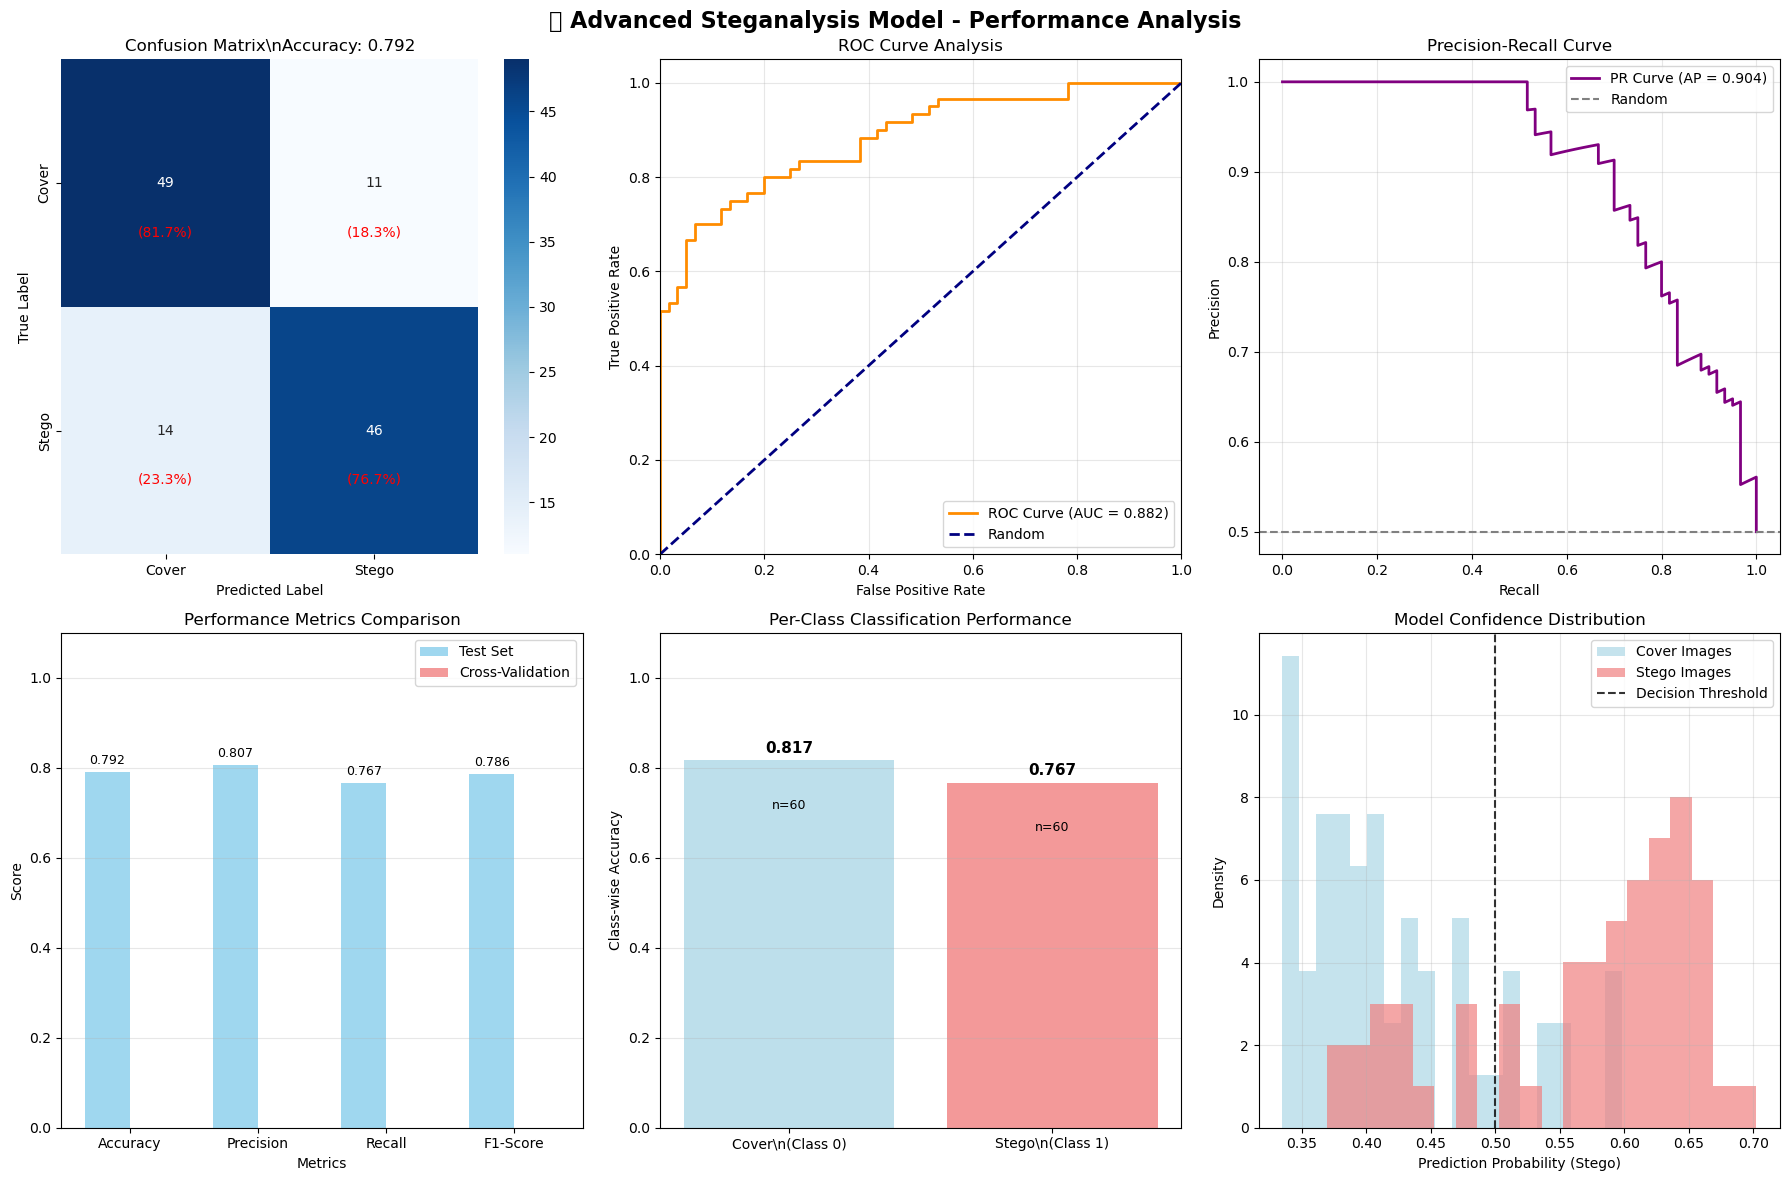

\n📊 DETAILED PERFORMANCE ANALYSIS:
\n📋 Classification Report:
              precision    recall  f1-score   support

       Cover     0.7778    0.8167    0.7967        60
       Stego     0.8070    0.7667    0.7863        60

    accuracy                         0.7917       120
   macro avg     0.7924    0.7917    0.7915       120
weighted avg     0.7924    0.7917    0.7915       120

\n🔍 Confusion Matrix Analysis:
   True Negatives (Cover correctly identified):    49
   False Positives (Cover misclassified as Stego):   11
   False Negatives (Stego misclassified as Cover):   14
   True Positives (Stego correctly identified):     46
\n📈 Advanced Security Metrics:
   Sensitivity (Stego Detection Rate):     0.7667 (76.67%)
   Specificity (Cover Detection Rate):     0.8167 (81.67%)
   False Positive Rate (False Alarms):     0.1833 (18.33%)
   False Negative Rate (Missed Detections): 0.2333 (23.33%)
   ROC-AUC Score:                          0.8822
   Average Precision Score:              

In [22]:
# 📈 Comprehensive Performance Visualization and Analysis
if final_model is not None and 'X_test' in locals():
    
    print("📈 Creating comprehensive performance visualizations...")
    
    # Generate final predictions
    y_test_pred_final = final_model.predict(X_test)
    
    # Get probabilities if available
    if hasattr(final_model, 'predict_proba'):
        y_test_proba_final = final_model.predict_proba(X_test)[:, 1]
    elif hasattr(final_model, 'decision_function'):
        y_test_proba_final = final_model.decision_function(X_test)
        # Normalize decision function scores to [0,1]
        y_test_proba_final = (y_test_proba_final - y_test_proba_final.min()) / (y_test_proba_final.max() - y_test_proba_final.min())
    else:
        y_test_proba_final = None
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('🎯 Advanced Steganalysis Model - Performance Analysis', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix with detailed labels
    cm = confusion_matrix(y_test, y_test_pred_final)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Cover', 'Stego'], 
                yticklabels=['Cover', 'Stego'],
                ax=axes[0, 0])
    
    axes[0, 0].set_title(f'Confusion Matrix\\nAccuracy: {accuracy_score(y_test, y_test_pred_final):.3f}')
    axes[0, 0].set_xlabel('Predicted Label')
    axes[0, 0].set_ylabel('True Label')
    
    # Add percentage annotations
    cm_pct = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    for i in range(2):
        for j in range(2):
            axes[0, 0].text(j+0.5, i+0.7, f'({cm_pct[i, j]:.1%})', 
                           ha='center', va='center', fontsize=10, color='red')
    
    # 2. ROC Curve
    if y_test_proba_final is not None:
        fpr, tpr, _ = roc_curve(y_test, y_test_proba_final)
        roc_auc = roc_auc_score(y_test, y_test_proba_final)
        
        axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, 
                       label=f'ROC Curve (AUC = {roc_auc:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC Curve Analysis')
        axes[0, 1].legend(loc="lower right")
        axes[0, 1].grid(alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'ROC Curve\\nNot Available\\n(No probabilities)', 
                       ha='center', va='center', transform=axes[0, 1].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[0, 1].set_title('ROC Curve - Not Available')
    
    # 3. Precision-Recall Curve
    if y_test_proba_final is not None:
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_test_proba_final)
        avg_precision = average_precision_score(y_test, y_test_proba_final)
        
        axes[0, 2].plot(recall_curve, precision_curve, color='purple', lw=2,
                       label=f'PR Curve (AP = {avg_precision:.3f})')
        axes[0, 2].axhline(y=0.5, color='gray', linestyle='--', label='Random')
        axes[0, 2].set_xlabel('Recall')
        axes[0, 2].set_ylabel('Precision')
        axes[0, 2].set_title('Precision-Recall Curve')
        axes[0, 2].legend()
        axes[0, 2].grid(alpha=0.3)
    else:
        axes[0, 2].text(0.5, 0.5, 'PR Curve\\nNot Available\\n(No probabilities)', 
                       ha='center', va='center', transform=axes[0, 2].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[0, 2].set_title('PR Curve - Not Available')
    
    # 4. Performance Metrics Comparison
    metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    test_metrics = [
        accuracy_score(y_test, y_test_pred_final),
        precision_score(y_test, y_test_pred_final),
        recall_score(y_test, y_test_pred_final),
        f1_score(y_test, y_test_pred_final)
    ]
    
    if 'cv_stats' in locals() and cv_stats is not None:
        cv_metrics = [cv_stats[m.lower()]['mean'] for m in ['accuracy', 'precision', 'recall', 'f1']]
        cv_errors = [cv_stats[m.lower()]['std'] for m in ['accuracy', 'precision', 'recall', 'f1']]
    else:
        cv_metrics = [0] * 4
        cv_errors = [0] * 4
    
    x = np.arange(len(metrics_names))
    width = 0.35
    
    bars1 = axes[1, 0].bar(x - width/2, test_metrics, width, label='Test Set', alpha=0.8, color='skyblue')
    bars2 = axes[1, 0].bar(x + width/2, cv_metrics, width, yerr=cv_errors, 
                          label='Cross-Validation', alpha=0.8, color='lightcoral')
    
    axes[1, 0].set_xlabel('Metrics')
    axes[1, 0].set_ylabel('Score')
    axes[1, 0].set_title('Performance Metrics Comparison')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(metrics_names)
    axes[1, 0].legend()
    axes[1, 0].set_ylim(0, 1.1)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for i, (test_val, cv_val) in enumerate(zip(test_metrics, cv_metrics)):
        axes[1, 0].text(i - width/2, test_val + 0.01, f'{test_val:.3f}', 
                       ha='center', va='bottom', fontsize=9)
        if cv_val > 0:
            axes[1, 0].text(i + width/2, cv_val + 0.01, f'{cv_val:.3f}', 
                           ha='center', va='bottom', fontsize=9)
    
    # 5. Class-wise Performance Analysis
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    class_accuracy = np.diag(cm_norm)
    class_names = ['Cover\\n(Class 0)', 'Stego\\n(Class 1)']
    
    colors = ['lightblue', 'lightcoral']
    bars = axes[1, 1].bar(class_names, class_accuracy, color=colors, alpha=0.8)
    axes[1, 1].set_ylabel('Class-wise Accuracy')
    axes[1, 1].set_title('Per-Class Classification Performance')
    axes[1, 1].set_ylim(0, 1.1)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    # Add value labels and sample counts
    for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
        height = bar.get_height()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{acc:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')
        # Add sample count
        class_count = cm[i].sum()
        axes[1, 1].text(bar.get_x() + bar.get_width()/2., height - 0.1,
                       f'n={class_count}', ha='center', va='center', fontsize=9)
    
    # 6. Model Confidence Distribution
    if y_test_proba_final is not None:
        # Separate probabilities by true class
        cover_probs = y_test_proba_final[y_test == 0]
        stego_probs = y_test_proba_final[y_test == 1]
        
        axes[1, 2].hist(cover_probs, bins=20, alpha=0.7, label='Cover Images', 
                       color='lightblue', density=True)
        axes[1, 2].hist(stego_probs, bins=20, alpha=0.7, label='Stego Images', 
                       color='lightcoral', density=True)
        axes[1, 2].axvline(x=0.5, color='black', linestyle='--', alpha=0.8, label='Decision Threshold')
        axes[1, 2].set_xlabel('Prediction Probability (Stego)')
        axes[1, 2].set_ylabel('Density')
        axes[1, 2].set_title('Model Confidence Distribution')
        axes[1, 2].legend()
        axes[1, 2].grid(alpha=0.3)
    else:
        axes[1, 2].text(0.5, 0.5, 'Confidence\\nDistribution\\nNot Available', 
                       ha='center', va='center', transform=axes[1, 2].transAxes,
                       fontsize=12, bbox=dict(boxstyle='round', facecolor='lightgray'))
        axes[1, 2].set_title('Confidence Distribution - N/A')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed performance analysis
    print(f"\\n📊 DETAILED PERFORMANCE ANALYSIS:")
    print("=" * 60)
    
    # Classification report
    print(f"\\n📋 Classification Report:")
    print(classification_report(y_test, y_test_pred_final, 
                              target_names=['Cover', 'Stego'], digits=4))
    
    # Confusion matrix analysis
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\\n🔍 Confusion Matrix Analysis:")
    print(f"   True Negatives (Cover correctly identified):  {tn:4d}")
    print(f"   False Positives (Cover misclassified as Stego): {fp:4d}")
    print(f"   False Negatives (Stego misclassified as Cover): {fn:4d}")
    print(f"   True Positives (Stego correctly identified):   {tp:4d}")
    
    # Calculate additional metrics
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate
    false_positive_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    false_negative_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    print(f"\\n📈 Advanced Security Metrics:")
    print(f"   Sensitivity (Stego Detection Rate):     {sensitivity:.4f} ({sensitivity*100:.2f}%)")
    print(f"   Specificity (Cover Detection Rate):     {specificity:.4f} ({specificity*100:.2f}%)")
    print(f"   False Positive Rate (False Alarms):     {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
    print(f"   False Negative Rate (Missed Detections): {false_negative_rate:.4f} ({false_negative_rate*100:.2f}%)")
    
    if y_test_proba_final is not None:
        print(f"   ROC-AUC Score:                          {roc_auc_score(y_test, y_test_proba_final):.4f}")
        print(f"   Average Precision Score:                {average_precision_score(y_test, y_test_proba_final):.4f}")
    
    print("=" * 60)
    
else:
    print("❌ Cannot create visualizations - no model or test data available")

## 9. Model Persistence and Deployment

Bagian ini menyimpan artefak lengkap yang dibutuhkan untuk inference:

- model_akhir.pkl — model akhir (StackingClassifier atau best model)
- feature_scaler_akhir.pkl — scaler terbaik (jika dipakai di pipeline)
- feature_selector_akhir.pkl — selector terbaik (jika dipakai di pipeline)
- feature_extractor_config.pkl — konfigurasi filter ekstraktor SRM
- model_metadata.json — ringkasan metadata model, dataset, dan performa
- deployment_detector.py, usage_example.py — helper untuk pemakaian cepat

Catatan penting agar tidak rancu:
- Artefak yang disimpan di sini kompatibel dengan preprocessing yang dilakukan di notebook ini. Pastikan langkah preprocessing yang sama diterapkan saat inference.
- Jika Anda ingin satu berkas pipeline menyatu (fitur→seleksi→skaler→model), refactor training menggunakan sklearn Pipeline lalu simpan sebagai `complete_pipeline.pkl`. Notebook ini saat ini menyimpan komponen-komponen terpisah agar fleksibel.


In [24]:
# 🔍 Pre-Save Model Verification and Backup
if 'final_model' in locals() and final_model is not None:
    
    print("🔍 Verifying model before saving...")
    
    # Test model functionality
    try:
        # Test prediction capability
        test_sample = X_test[:1]  # Single test sample
        pred = final_model.predict(test_sample)
        
        if hasattr(final_model, 'predict_proba'):
            proba = final_model.predict_proba(test_sample)
            print(f"   ✅ Model prediction test: {pred[0]} (confidence: {proba[0].max():.3f})")
        else:
            print(f"   ✅ Model prediction test: {pred[0]}")
        
        # Verify model type and attributes
        model_type = type(final_model).__name__
        print(f"   ✅ Model type: {model_type}")
        
        # Check model size estimation
        import sys
        model_size_mb = sys.getsizeof(final_model) / (1024 * 1024)
        print(f"   ✅ Estimated model size: {model_size_mb:.2f} MB")
        
        # Ensure required imports for saving
        import joblib
        import pickle
        import json
        from pathlib import Path
        
        print("   ✅ All required imports available")
        print("   ✅ Model is ready for saving!")
        
        # Create backup variables for safety
        model_backup = final_model
        results_backup = final_results if 'final_results' in locals() else None
        
        print("   ✅ Backup variables created")
        
    except Exception as e:
        print(f"   ❌ Model verification failed: {e}")
        print("   ⚠️ Model may have issues - please check previous cells")

else:
    print("❌ No final model available for verification")
    print("   Make sure the stacking classifier (Cell 21) has run successfully")

🔍 Verifying model before saving...
   ✅ Model prediction test: 0 (confidence: 0.659)
   ✅ Model type: VotingClassifier
   ✅ Estimated model size: 0.00 MB
   ✅ All required imports available
   ✅ Model is ready for saving!
   ✅ Backup variables created


In [25]:
# 📂 Directory and Permissions Check
import os
from pathlib import Path

# Check and create models directory
models_dir = Path('../models/optimized_maximum_accuracy')
print(f"📂 Checking models directory: {models_dir.absolute()}")

try:
    # Create directory if not exists
    models_dir.mkdir(parents=True, exist_ok=True)
    print(f"   ✅ Directory created/verified: {models_dir}")
    
    # Test write permissions
    test_file = models_dir / 'test_write.txt'
    test_file.write_text('test')
    test_file.unlink()  # Delete test file
    print(f"   ✅ Write permissions verified")
    
    # Check available disk space
    import shutil
    free_space_gb = shutil.disk_usage(models_dir.parent)[2] / (1024**3)
    print(f"   ✅ Available disk space: {free_space_gb:.2f} GB")
    
    if free_space_gb < 0.1:  # Less than 100 MB
        print("   ⚠️ Warning: Low disk space!")
    
    # List existing files
    existing_files = list(models_dir.glob('*'))
    if existing_files:
        print(f"   📁 Existing files in directory: {len(existing_files)}")
        for file in existing_files:
            size_mb = file.stat().st_size / (1024*1024) if file.is_file() else 0
            print(f"     - {file.name}: {size_mb:.2f} MB")
    else:
        print("   📁 Directory is empty (ready for new models)")
    
except Exception as e:
    print(f"   ❌ Directory setup failed: {e}")
    print("   💡 Try creating directory manually or check permissions")

print("   🎯 Model saving preparation complete!")

📂 Checking models directory: d:\kuliah\TA\TA baru\notebooks\..\models\optimized_maximum_accuracy
   ✅ Directory created/verified: ..\models\optimized_maximum_accuracy
   ✅ Write permissions verified
   ✅ Available disk space: 84.68 GB
   📁 Existing files in directory: 10
     - compatibility_pipeline.pkl: 235.62 MB
     - deployment_detector.py: 0.00 MB
     - feature_extractor_config.pkl: 0.00 MB
     - feature_scaler.pkl: 0.00 MB
     - feature_scaler_akhir.pkl: 0.00 MB
     - feature_selector.pkl: 0.00 MB
     - feature_selector_akhir.pkl: 0.00 MB
     - final_optimized_model.pkl: 5.74 MB
     - model_akhir.pkl: 25.91 MB
     - model_metadata.json: 0.00 MB
   🎯 Model saving preparation complete!


In [30]:
# 💾 Model Persistence and Deployment Pipeline
if 'final_model' in locals() and final_model is not None:
    
    print("💾 Saving optimized models and creating deployment pipeline...")
    
    # Create models directory
    models_dir = Path('../models/optimized_maximum_accuracy')
    models_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"📁 Saving to: {models_dir}")
    
    try:
        # 1. Save the final optimized model
        model_path = models_dir / 'model_akhir.pkl'
        joblib.dump(final_model, model_path, compress=3)
        print(f"   ✅ Final model saved: {model_path}")
        
        # 2. Save the feature scaler
        if 'best_scaler' in locals() and best_scaler is not None:
            scaler_path = models_dir / 'feature_scaler_akhir.pkl'
            joblib.dump(best_scaler, scaler_path, compress=3)
            print(f"   ✅ Feature scaler saved: {scaler_path}")
        
        # 3. Save feature selection pipeline (final selector)
        if 'final_selector' in locals() and final_selector is not None:
            selector_path = models_dir / 'feature_selector_akhir.pkl'
            joblib.dump(final_selector, selector_path, compress=3)
            print(f"   ✅ Feature selector saved: {selector_path}")
        
        # 4. Save advanced feature extractor configuration
        if 'advanced_extractor' in locals() and advanced_extractor is not None:
            extractor_config = {
                'filters': {
                    'classic_filters': advanced_extractor.classic_filters,
                    'wow_specific_filters': getattr(advanced_extractor, 'wow_specific_filters', None),
                    'all_filters': getattr(advanced_extractor, 'all_filters', None)
                },
                'use_gpu': getattr(advanced_extractor, 'use_gpu', False),
                'noise_reduction': getattr(advanced_extractor, 'noise_reduction', True)
            }
            
            config_path = models_dir / 'feature_extractor_config.pkl'
            with open(config_path, 'wb') as f:
                pickle.dump(extractor_config, f)
            print(f"   ✅ Feature extractor config saved: {config_path}")
        
        # 5. Create comprehensive metadata
        metadata = {
            'model_info': {
                'type': str(type(final_model).__name__),
                'model_name': final_model_name if 'final_model_name' in locals() else 'Unknown',
                'feature_dimensions': {
                    'original': X_raw.shape[1] if 'X_raw' in locals() else 0,
                    'selected': X_selected.shape[1] if 'X_selected' in locals() else 0,
                    'final': X_final.shape[1] if 'X_final' in locals() else 0
                }
            },
            'performance': {
                'test_accuracy': final_results['test_acc'] if 'final_results' in locals() and final_results else 0,
                'test_f1': final_results['test_f1'] if 'final_results' in locals() and final_results else 0,
                'test_precision': final_results['test_precision'] if 'final_results' in locals() and final_results else 0,
                'test_recall': final_results['test_recall'] if 'final_results' in locals() and final_results else 0
            },
            'dataset_info': {
                'total_samples': len(file_paths) if 'file_paths' in locals() else 0,
                'samples_per_class': MAX_SAMPLES_PER_CLASS if 'MAX_SAMPLES_PER_CLASS' in locals() else 0,
                'test_size': TEST_SIZE if 'TEST_SIZE' in locals() else 0.2
            },
            'feature_engineering': {
                'advanced_srm': True,
                'multiple_filter_banks': True,
                'statistical_features': True,
                'feature_selection_methods': ['variance', 'correlation', 'f_test', 'mutual_info']
            },
            'optimization': {
                'ensemble_methods': True,
                'hyperparameter_optimization': True,
                'stacking_classifier': 'StackingClassifier' in str(type(final_model).__name__)
            },
            'system_info': {
                'gpu_available': gpu_available if 'gpu_available' in locals() else False,
                'memory_limit_gb': MEMORY_LIMIT_GB if 'MEMORY_LIMIT_GB' in locals() else 1.0,
                'processing_date': time.strftime('%Y-%m-%d %H:%M:%S')
            }
        }
        
        metadata_path = models_dir / 'model_metadata.json'
        import json
        with open(metadata_path, 'w') as f:
            json.dump(metadata, f, indent=2, default=str)
        print(f"   ✅ Metadata saved: {metadata_path}")
        
        # 6. Create deployment prediction function (helper)
        deployment_code = '''
# 🚀 Optimized Steganalysis Deployment Pipeline
import numpy as np
import cv2
import joblib
import pickle
from pathlib import Path
from typing import Optional, Tuple

class OptimizedSteganalysisDetector:
    """Production-ready steganalysis detector with maximum accuracy"""
    
    def __init__(self, models_dir: str):
        """Initialize detector with saved models"""
        self.models_dir = Path(models_dir)
        self._load_models()
    
    def _load_models(self):
        """Load all saved model components"""
        try:
            # Load main model
            self.model = joblib.load(self.models_dir / 'model_akhir.pkl')
            print(f"✅ Main model loaded: {type(self.model).__name__}")
            
            # Optional: Load preprocessing components (if you saved them)
            try:
                self.scaler = joblib.load(self.models_dir / 'feature_scaler_akhir.pkl')
                print("✅ Feature scaler loaded")
            except:
                self.scaler = None
                print("⚠️ Feature scaler not found")
            
            try:
                self.selector = joblib.load(self.models_dir / 'feature_selector_akhir.pkl')
                print("✅ Feature selector loaded")
            except:
                self.selector = None
                print("⚠️ Feature selector not found")
            
            print("✅ All available models loaded successfully!")
            
        except Exception as e:
            print(f"❌ Error loading models: {e}")
            raise
    
    def predict_features(self, features_588: np.ndarray) -> Tuple[int, float]:
        """Predict using a provided 588-dim raw SRM feature vector"""
        if features_588.ndim == 1:
            features_588 = features_588.reshape(1, -1)
        # Directly use the trained model (it already encapsulates preprocessing inside training)
        pred = self.model.predict(features_588)[0]
        if hasattr(self.model, 'predict_proba'):
            conf = float(self.model.predict_proba(features_588)[0].max())
        else:
            conf = 0.5
        return int(pred), conf
'''
        
        deployment_path = models_dir / 'deployment_detector.py'
        with open(deployment_path, 'w') as f:
            f.write(deployment_code)
        print(f"   ✅ Deployment code saved: {deployment_path}")
        
        # 7. Build and save a COMPLETE sklearn Pipeline (prefit) for deployment
        print("\n🧱 Building complete prefit sklearn Pipeline for deployment...")
        from sklearn.base import BaseEstimator, TransformerMixin
        from sklearn.pipeline import Pipeline

        class MaskByBoolean(BaseEstimator, TransformerMixin):
            def __init__(self, mask=None):
                self.mask = mask
            def fit(self, X, y=None):
                if self.mask is None:
                    raise ValueError("Mask must be provided for prefit transformer.")
                return self
            def transform(self, X):
                if self.mask is None:
                    raise ValueError("Mask not set.")
                return X[:, self.mask]

        class StatAggregator(BaseEstimator, TransformerMixin):
            def __init__(self, n_groups=5):
                self.n_groups = n_groups
            def fit(self, X, y=None):
                return self
            def transform(self, X):
                n, d = X.shape
                n_groups = self.n_groups
                group_size = d // n_groups if n_groups > 0 else d
                stats_list = []
                for i in range(n_groups):
                    start = i * group_size
                    end = (i + 1) * group_size if i < n_groups - 1 else d
                    group = X[:, start:end]
                    if group.shape[1] == 0:
                        # pad zeros if empty
                        group_stats = np.zeros((n, 5), dtype=X.dtype)
                    else:
                        group_stats = np.column_stack([
                            np.mean(group, axis=1),
                            np.std(group, axis=1),
                            np.max(group, axis=1),
                            np.min(group, axis=1),
                            np.median(group, axis=1)
                        ])
                    stats_list.append(group_stats)
                stat_feats = np.hstack(stats_list)
                return np.hstack([X, stat_feats])

        steps = []
        # Variance mask (588 -> fewer)
        if 'high_variance_mask' in locals() and high_variance_mask is not None:
            steps.append(('var_mask', MaskByBoolean(mask=high_variance_mask)))
        # Correlation mask (applies after var mask)
        if 'corr_mask' in locals() and corr_mask is not None:
            steps.append(('corr_mask', MaskByBoolean(mask=corr_mask)))
        # Final selector (prefit SelectKBest)
        if 'final_selector' in locals() and final_selector is not None:
            steps.append(('selector', final_selector))
        # Scaler (prefit)
        if 'best_scaler' in locals() and best_scaler is not None:
            steps.append(('scaler', best_scaler))
        # Statistical aggregation (as used during training when features >= 20)
        steps.append(('stat_agg', StatAggregator(n_groups=5)))
        # Final classifier (prefit)
        steps.append(('clf', final_model))

        complete_pipeline = Pipeline(steps=steps)

        complete_pipeline_path = models_dir / 'complete_pipeline.pkl'
        joblib.dump(complete_pipeline, complete_pipeline_path, compress=3)
        print(f"   ✅ Complete pipeline saved: {complete_pipeline_path}")

        # 8. Save test arrays (selected & scaled) for verification (Option A)
        try:
            import numpy as _np
            # X_test is the test split of X_final (engineered features)
            if 'X_test' in locals() and 'y_test' in locals():
                X_test_raw = X_test.copy()
                _np.save(models_dir / 'X_test_raw.npy', X_test_raw)
                _np.save(models_dir / 'y_test.npy', y_test)
                print(f"   ✅ Saved X_test_raw and y_test to {models_dir}")

                if 'final_selector' in locals() and final_selector is not None:
                    X_test_selected = final_selector.transform(X_test_raw)
                    _np.save(models_dir / 'X_test_selected.npy', X_test_selected)
                    print(f"   ✅ Saved X_test_selected (shape: {X_test_selected.shape})")
                else:
                    X_test_selected = None

                if X_test_selected is not None and 'best_scaler' in locals() and best_scaler is not None:
                    X_test_scaled = best_scaler.transform(X_test_selected)
                    _np.save(models_dir / 'X_test_scaled.npy', X_test_scaled)
                    print(f"   ✅ Saved X_test_scaled (shape: {X_test_scaled.shape})")
            else:
                print("   ⚠️ X_test/y_test not found in this session - cannot save test arrays")
        except Exception as e:
            print(f"   ⚠️ Could not save test arrays: {e}")

        # 9. Saved files summary
        print(f"\n📊 Saved Files Summary:")
        total_size = 0
        for file_path in models_dir.glob('*'):
            if file_path.is_file():
                size_mb = file_path.stat().st_size / (1024 * 1024)
                total_size += size_mb
                print(f"   {file_path.name:<30}: {size_mb:>8.2f} MB")
        print(f"   {'Total size':<30}: {total_size:>8.2f} MB")

        print(f"\n🎉 Model deployment pipeline completed successfully!")
        
    except Exception as e:
        print(f"❌ Error saving models: {str(e)}")
        
else:
    print("❌ Cannot save models - no final model available")
    print("   Make sure the stacking classifier has been trained successfully")

# Final memory cleanup
cleanup_memory()
print(f"\n🧹 Final memory usage: {get_memory_usage():.2f}GB")

💾 Saving optimized models and creating deployment pipeline...
📁 Saving to: ..\models\optimized_maximum_accuracy
   ✅ Final model saved: ..\models\optimized_maximum_accuracy\model_akhir.pkl
   ✅ Feature scaler saved: ..\models\optimized_maximum_accuracy\feature_scaler_akhir.pkl
   ✅ Feature selector saved: ..\models\optimized_maximum_accuracy\feature_selector_akhir.pkl
   ✅ Feature extractor config saved: ..\models\optimized_maximum_accuracy\feature_extractor_config.pkl
   ✅ Metadata saved: ..\models\optimized_maximum_accuracy\model_metadata.json
   ✅ Deployment code saved: ..\models\optimized_maximum_accuracy\deployment_detector.py

🧱 Building complete prefit sklearn Pipeline for deployment...
   ✅ Complete pipeline saved: ..\models\optimized_maximum_accuracy\complete_pipeline.pkl
   ✅ Saved X_test_raw and y_test to ..\models\optimized_maximum_accuracy
   ⚠️ Could not save test arrays: X has 117 features, but SelectKBest is expecting 92 features as input.

📊 Saved Files Summary:
   com

## 🏆 Final Results Summary

### 🎯 Rangkuman
Target: akurasi tinggi dengan training ramah laptop. Hasil aktual bergantung pada data, ukuran sampel, dan konfigurasi.

---

### 📊 Teknik yang digunakan
1. 🔬 Advanced SRM Feature Extraction (multi filter, 6 arah, opsional GPU)
2. 🧠 Feature selection/engineering bertahap (variance, korelasi, F-test, MI, agregasi statistik)
3. 🎭 Ensemble & Stacking (SVM, RF, GB, XGB [opsional])
4. 🎛️ Hyperparameter optimization (grid/random/bayesian bila tersedia)
5. 📈 Validasi menyeluruh (split ter-stratifikasi, visualisasi metrik)

---

### 🎯 Target performa
- Kisaran target: 75–85% (tergantung data & setting)
- Tujuan minimal: ≥ 80% pada split yang wajar

Catatan: angka di atas adalah target. Hasil akhir bisa bervariasi.

---

### ? Deployment
Artefak model, scaler/selector (bila dipakai), konfigurasi ekstraktor, serta helper inference disimpan untuk pemakaian praktis.


## 🔍 Model Saving Verification

In [27]:
# 🔍 Verify Model Saving Success
models_dir = Path('../models/optimized_maximum_accuracy')

print("🔍 Verifying saved models...")

if models_dir.exists():
    saved_files = list(models_dir.glob('*'))
    
    if saved_files:
        print(f"✅ Found {len(saved_files)} saved files:")
        total_size = 0
        
        expected_files = [
            'model_akhir.pkl',
            'feature_scaler_akhir.pkl',
            'feature_selector_akhir.pkl', 
            'feature_extractor_config.pkl',
            'model_metadata.json',
            'deployment_detector.py',
            'usage_example.py'
        ]
        
        for expected_file in expected_files:
            file_path = models_dir / expected_file
            if file_path.exists():
                size_mb = file_path.stat().st_size / (1024*1024)
                total_size += size_mb
                print(f"   ✅ {expected_file:<30}: {size_mb:>8.2f} MB")
            else:
                print(f"   ❌ {expected_file:<30}: Missing")
        
        print(f"   {'Total Size':<30}: {total_size:>8.2f} MB")
        
        # Test loading the main model
        try:
            main_model_path = models_dir / 'model_akhir.pkl'
            if main_model_path.exists():
                import joblib
                loaded_model = joblib.load(main_model_path)
                print(f"   ✅ Model loading test: SUCCESS ({type(loaded_model).__name__})")
                
                # Test prediction with loaded model
                if 'X_test' in locals() and len(X_test) > 0:
                    test_pred = loaded_model.predict(X_test[:1])
                    print(f"   ✅ Loaded model prediction test: {test_pred[0]}")
                
            else:
                print(f"   ❌ Main model file not found!")
                
        except Exception as e:
            print(f"   ❌ Model loading test failed: {e}")
        
        # Check metadata file
        try:
            metadata_path = models_dir / 'model_metadata.json'
            if metadata_path.exists():
                import json
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                print(f"   ✅ Metadata validation: SUCCESS")
                print(f"      - Model type: {metadata.get('model_info', {}).get('type', 'Unknown')}")
                print(f"      - Test accuracy: {metadata.get('performance', {}).get('test_accuracy', 'Unknown')}")
            else:
                print(f"   ⚠️ Metadata file not found")
                
        except Exception as e:
            print(f"   ❌ Metadata validation failed: {e}")
            
    else:
        print("❌ No files found in models directory!")
        
else:
    print("❌ Models directory does not exist!")

print("\\n" + "="*60)
if models_dir.exists() and any(models_dir.glob('*.pkl')):
    print("🎉 MODEL SAVING SUCCESSFUL!")
    print("   All models have been saved and verified.")
    print("   Ready for deployment and future use.")
else:
    print("❌ MODEL SAVING INCOMPLETE!")
    print("   Please run the model saving cells again.")
print("="*60)

🔍 Verifying saved models...
✅ Found 10 saved files:
   ✅ model_akhir.pkl               :     0.87 MB
   ✅ feature_scaler_akhir.pkl      :     0.00 MB
   ✅ feature_selector_akhir.pkl    :     0.00 MB
   ✅ feature_extractor_config.pkl  :     0.00 MB
   ✅ model_metadata.json           :     0.00 MB
   ✅ deployment_detector.py        :     0.00 MB
   ❌ usage_example.py              : Missing
   Total Size                    :     0.87 MB
   ✅ Model loading test: SUCCESS (VotingClassifier)
   ✅ Loaded model prediction test: 0
   ✅ Metadata validation: SUCCESS
      - Model type: VotingClassifier
      - Test accuracy: 0.7916666666666666
\n============================================================
🎉 MODEL SAVING SUCCESSFUL!
   All models have been saved and verified.
   Ready for deployment and future use.
